# Midterm Project: Traffic IoT
#### Victoria Anguix López - 100516919

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from datetime import datetime, timedelta

#### References
- Data: https://www.kaggle.com/datasets/vetrirah/ml-iot?select=sample_submission_ML_IOT.csv   
- Section 1.2 Outlier detection: https://www.kaggle.com/code/yasinsametkaraca/lstm-time-series-in-iot-traffic-prediction 

## 1. Preprocessing and visualization

The dataset aims to support the transformation of our city into a smart city, emphasizing digital innovation and improved services for residents. Among the city's challenges, traffic congestion stands out, prompting efforts to implement a more efficient traffic system. To achieve this, we need to predict traffic patterns for the upcoming month based on the last 20 months of data, spanning 2015, 2016, and 2017. Here are the key characteristics of the original dataset:
- **Data Frequency**: Recorded hourly.
- **Key Features**: 
    - Date and Time
    - Junction ID (there are four separate Time Series for each junction)
    - Vehicle Count (the target variable)
    - Vehicle ID
- **Forecasting Horizon**: One month.

Let's start by visualizing the data and checking for any missing values or anomalies.

In [2]:
data= pd.read_csv('train_ML_IOT.csv')
data

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


In [3]:
#Ensuring the date column is in datetime format
data['DateTime'] = pd.to_datetime(data['DateTime'])
#Checking null values
data.isnull().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

In [4]:
data.shape


(48120, 4)

### 1.1. Agregating the data daily


Upon initial observation, we've identified a total of 48,120 hourly observations in our dataset. Given the nature of this project, which involves delving into time series analysis and manual forecasting, we have decided to aggregate the data to simplify seasonal patterns. Initially, we considered aggregating the data on a weekly basis, computing the mean of observations over complete weeks. However, we ultimately dismissed this option due to significant information loss, resulting in diminished autocorrelations across all time series.

Consequently, we opted to aggregate the data on a daily basis to preserve dataset integrity while still enabling the observation of weekly patterns. Additionally, we conducted a thorough check for null values and ensured data formatting consistency. Let's proceed to visualize the aggregated data and address any remaining formatting issues or missing values.

In [5]:
# Convert the 'DateTime' column to datetime type
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Convert the 'DateTime' column to daily frequency
data['DayPeriod'] = data['DateTime'].dt.to_period('D')

# Group by 'Junction' and 'DayPeriod', calculate the mean of the vehicles
daily_data = data.groupby(['Junction', 'DayPeriod'])['Vehicles'].mean().reset_index()

# Show the data
daily_data


,Junction,DayPeriod,Vehicles
0,1,2015-11-01,13.625000
1,1,2015-11-02,22.750000
2,1,2015-11-03,22.666667
3,1,2015-11-04,20.750000
4,1,2015-11-05,19.333333
...,...,...,...
2000,4,2017-06-26,7.541667
2001,4,2017-06-27,9.375000
2002,4,2017-06-28,11.500000
2003,4,2017-06-29,12.333333


In [6]:
daily_data.isnull().sum()

Junction     0
DayPeriod    0
Vehicles     0
dtype: int64

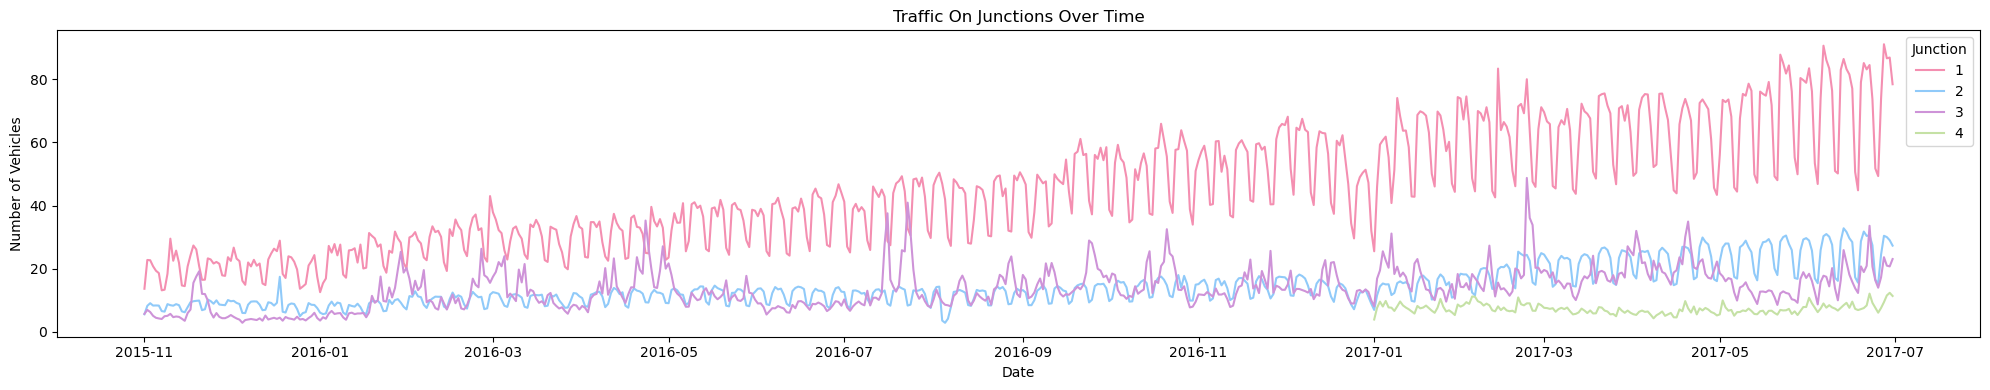

In [7]:
# Suppress warnings
warnings.filterwarnings("ignore")

daily_data['DayPeriod'] = daily_data['DayPeriod'].astype(str)
daily_data['DayPeriod'] = pd.to_datetime(daily_data['DayPeriod'])


# Define colors
colors = ["#F48FB1", "#90CAF9", "#CE93D8", "#C5E1A5"]

# Create the plot
plt.figure(figsize=(20, 4))
Time_series = sns.lineplot(x='DayPeriod', y="Vehicles", data=daily_data, hue="Junction", palette=colors)

# Configure title and labels
Time_series.set_title("Traffic On Junctions Over Time")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

# Show the plot
plt.tight_layout()
plt.show()



Upon initial examination of our Time Series data, we can address several key questions:

- **Is there a significant trend?** Notably, there appears to be an increasing trend, particularly evident in junction 1. For the remaining junctions, discerning trends is more challenging, warranting further exploration through decomposition.

- **Is seasonality important?** The data exhibits clear signs of seasonality, characterized by numerous oscillations across all four time series.

- **Is there evidence of the presence of business cycles?** While detecting business cycles proves challenging, preliminary observations suggest their absence.

- **Are there significant changes in volatility?** Junctions 1 and 2 demonstrate a slight increase in volatility, as indicated by graphical trends. However, confirmation through decomposition is necessary.

- **Are there any outliers in the data?** Junction 3 notably presents higher peaks compared to others, suggesting potential outliers. However, definitive conclusions require thorough testing.

We will delve deeper into these aspects through decomposition and statistical tests to gain a comprehensive understanding of our Time Series data.


To facilitate parallel analysis, we will create four new datasets, each corresponding to a specific junction. This approach allows for focused examination and individualized exploration of each Time Series.

Let's proceed by creating the four new datasets, one for each junction, to enable comprehensive analysis of our Time Series data.

In [8]:
# I used the pivot method to create the junction category tables.
data_junctions = daily_data.pivot(columns="Junction", index="DayPeriod")  # Junction 1,2,3,4 columns
data_junctions

Vehicles                                 
Junction            1          2          3          4
DayPeriod                                             
2015-11-01  13.625000   5.541667   5.666667        NaN
2015-11-02  22.750000   8.208333   6.916667        NaN
2015-11-03  22.666667   9.041667   6.250000        NaN
2015-11-04  20.750000   8.291667   5.041667        NaN
2015-11-05  19.333333   8.333333   4.416667        NaN
...               ...        ...        ...        ...
2017-06-26  73.916667  24.458333  17.250000   7.541667
2017-06-27  91.125000  30.416667  23.625000   9.375000
2017-06-28  86.666667  30.000000  20.958333  11.500000
2017-06-29  86.916667  29.000000  20.708333  12.333333
2017-06-30  78.458333  27.291667  23.041667  11.333333

[608 rows x 4 columns]

In [9]:
# I created a new dataframe for each junction.
data_junction_1 = data_junctions[[('Vehicles', 1)]] 
data_junction_2 = data_junctions[[('Vehicles', 2)]]
data_junction_3 = data_junctions[[('Vehicles', 3)]]
data_junction_4 = data_junctions[[('Vehicles', 4)]]
data_junction_4 = data_junction_4.dropna() # I dropped null values because there was limited data on Junction 4 for only a few months


list_data_junctions = [data_junction_1, data_junction_2, data_junction_3, data_junction_4]
for i in list_data_junctions:  # I removed the level one (level 1) column labels of a multi-level dataframe.
    i.columns= i.columns.droplevel(level=1)
data_junction_1.head()

,Vehicles
DayPeriod,
2015-11-01,13.625000
2015-11-02,22.750000
2015-11-03,22.666667
2015-11-04,20.750000
2015-11-05,19.333333


In [10]:
data_junction_1 = data_junction_1.reset_index()
data_junction_2 = data_junction_2.reset_index()
data_junction_3 = data_junction_3.reset_index()
data_junction_4 = data_junction_4.reset_index()

# Rename the columns
data_junction_1.columns = ['Date', 'Vehicles']
data_junction_2.columns = ['Date', 'Vehicles']
data_junction_3.columns = ['Date', 'Vehicles']
data_junction_4.columns = ['Date', 'Vehicles']

# Now data_junction_1 DataFrame will have two columns: 'DateTime' and 'Vehicles'
data_junction_1

,Date,Vehicles
0,2015-11-01,13.625000
1,2015-11-02,22.750000
2,2015-11-03,22.666667
3,2015-11-04,20.750000
4,2015-11-05,19.333333
...,...,...
603,2017-06-26,73.916667
604,2017-06-27,91.125000
605,2017-06-28,86.666667
606,2017-06-29,86.916667


### 1.2. Outlier detection

To detect outliers in our datasets, we will employ the method described in the Kaggle code, which relies on moving statistics and kurtosis for outlier detection. Here's a breakdown of how the method works:

1. Moving averages and standard deviations are computed for the time series. Specifically:
   - `rmeans`: Median value of the time series within a specified window size (`window_length`).
   - `rstd`: Standard deviation within the same window size.
   - `rstd_lower`: Standard deviation of data points lower than the `rmeans` value.

2. The kurtosis value of the time series, which describes the shape of the dataset by focusing on the frequency of peaks and troughs in the data distribution, is calculated and assigned to the variable `kurt`.

3. Upper and lower bounds are calculated using the moving averages (`rmeans`). 
   - `upper`: Represents the upper bound.
   - `lower`: Represents the lower bound. These bounds will be used for detecting outliers.

4. Outliers are defined as data points that exceed the upper bound (`idx1`) or fall below the lower bound (`idx2`).

5. Finally, the code combines the results of `idx1` and `idx2` to create the `idx` array, which contains all outlier data points.

We will implement this method to identify outliers in our datasets, enabling us to address any anomalies effectively.

In [11]:
j_1 = data_junction_1.copy()
j_2 = data_junction_2.copy()
j_3 = data_junction_3.copy()
j_4 = data_junction_4.copy()


all_junctions = [j_1, j_2, j_3, j_4]

In [12]:
def outlier_detection_kurtosis(junction, std_param = 3, window_length = 100):
    
    rmeans = junction.rolling(window_length, min_periods=1).median()
    rstd = junction.rolling(window_length, min_periods=1).std()
    rstd_lower = junction[junction<rmeans].rolling(window_length ,min_periods=1).std()
    
    kurtosis = j.kurt()
    upper = rmeans+std_param*rstd*np.exp(0.043*kurtosis)
    lower = rmeans - (4.87 * rstd_lower)    
    idx1 = (j>upper)
    idx2 = (j<lower)
    
    idx = idx1 | idx2
    
    return j, idx, rmeans, upper, lower

def plot_outlier_detection(j, idx, rmeans, upper, lower):
    plt.figure(figsize=(20, 4)) 
    plt.plot(j)
    plt.plot(upper, color = 'blue')
    plt.plot(lower, color = 'blue')
    plt.plot(rmeans, color = 'red')
    plt.xlabel("Date")
    plt.ylabel("Vehicles")
    plt.scatter(j.index[idx], j[idx], color = 'yellow', zorder=10)
    plt.show()

In [13]:
for i,j in enumerate(all_junctions):
    all_junctions[i] = j.Vehicles
    all_junctions[i].index = j.index

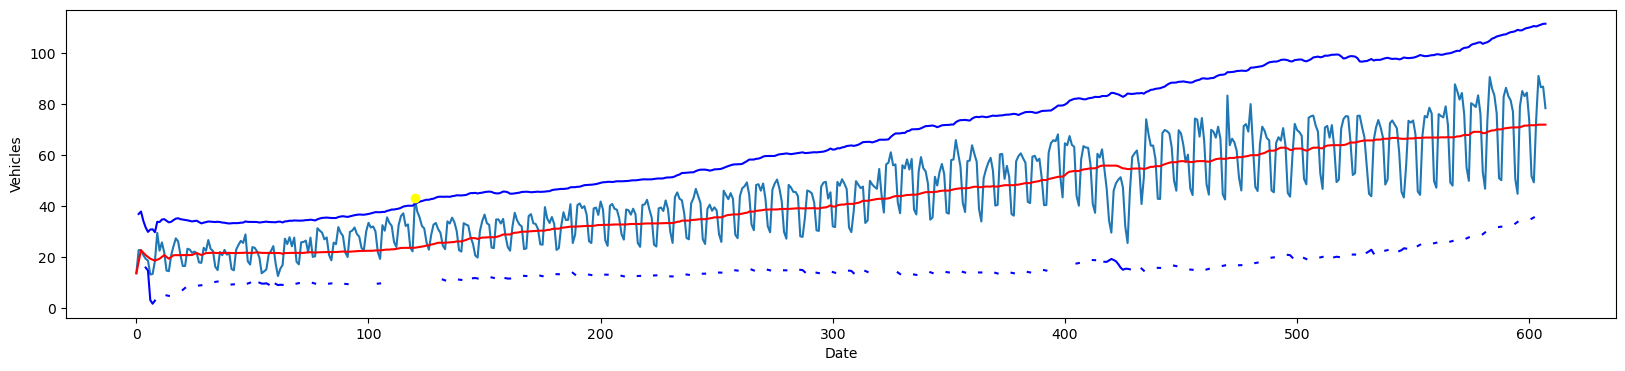

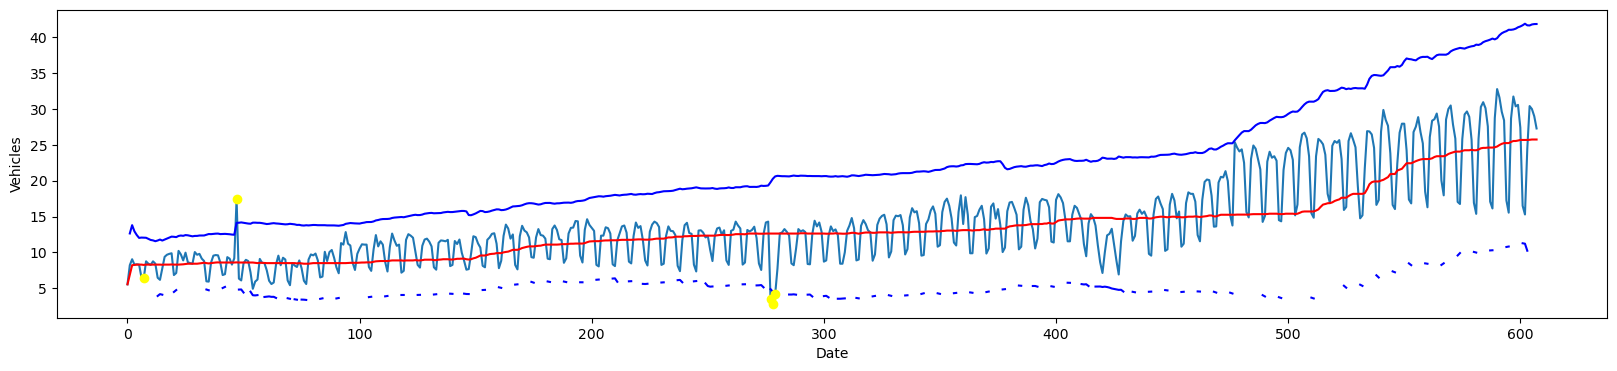

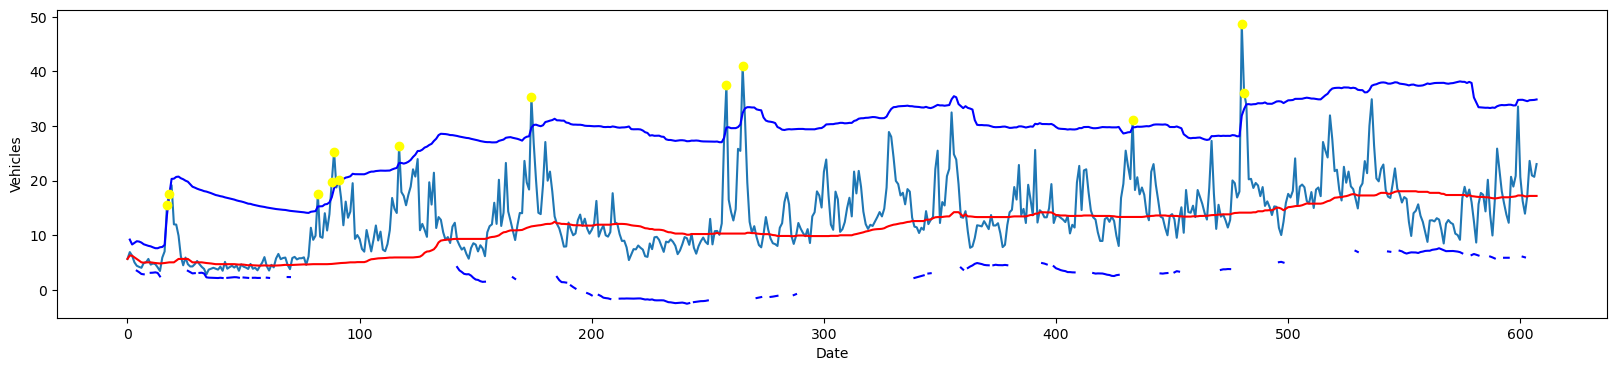

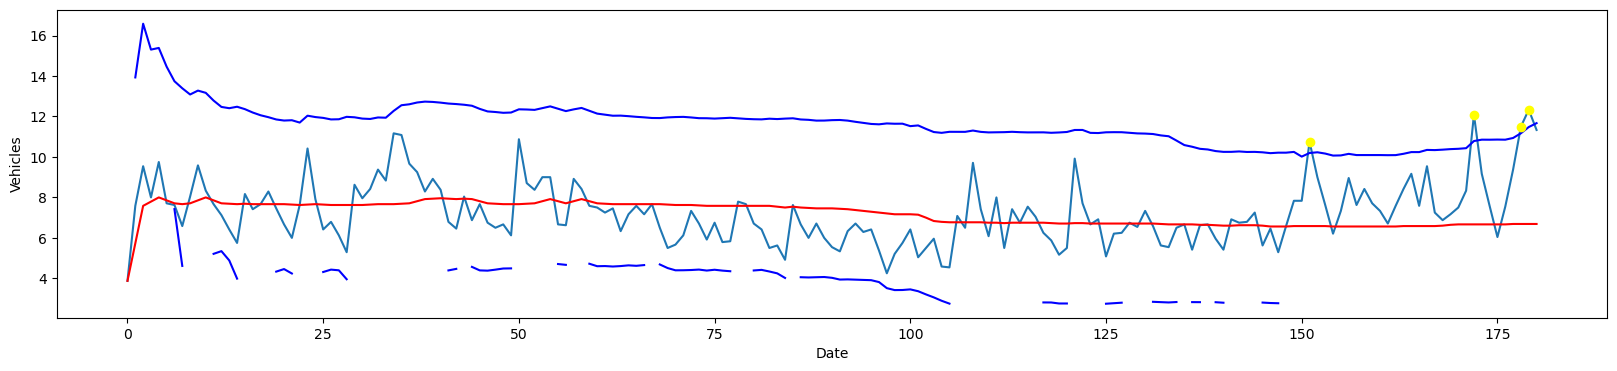

In [14]:
for j in all_junctions:
    j, idx, rmeans, upper, lower = outlier_detection_kurtosis(j)
    plot_outlier_detection(j, idx, rmeans, upper, lower)
    j[idx] = np.nan

Upon observation, it is evident that three out of four junctions exhibit minimal outliers. Conversely, junction 3 displays a slightly higher incidence of outliers. However, it is noteworthy that these outliers do not deviate significantly from the dataset. Consequently, we have made the decision to retain the dataset in its current state, as the outliers do not pose substantial concerns or require immediate intervention.

### 1.3. Time Series Decomposition

Continuing with the visualization of our Time Series, we will conduct a Time Series Decomposition to gain better insights into the trend, seasonality, and noise present in the data. This decomposition allows us to:

- **Identify Trend**: By isolating the trend component, we can discern long-term patterns or movements in the data, such as increasing or decreasing trends over time.

- **Detect Seasonality**: Separating out the seasonal component enables us to understand recurring patterns or fluctuations that occur at regular intervals, such as daily, weekly, or monthly cycles.

- **Assess Noise**: The residual component captures the random fluctuations or noise present in the data after removing the trend and seasonal effects. Analyzing the residual component helps us understand the unpredictability or randomness inherent in the Time Series.

By performing Time Series Decomposition, we aim to gain a deeper understanding of the underlying patterns and dynamics driving our data, facilitating more informed analysis and decision-making.

#### Junction 1

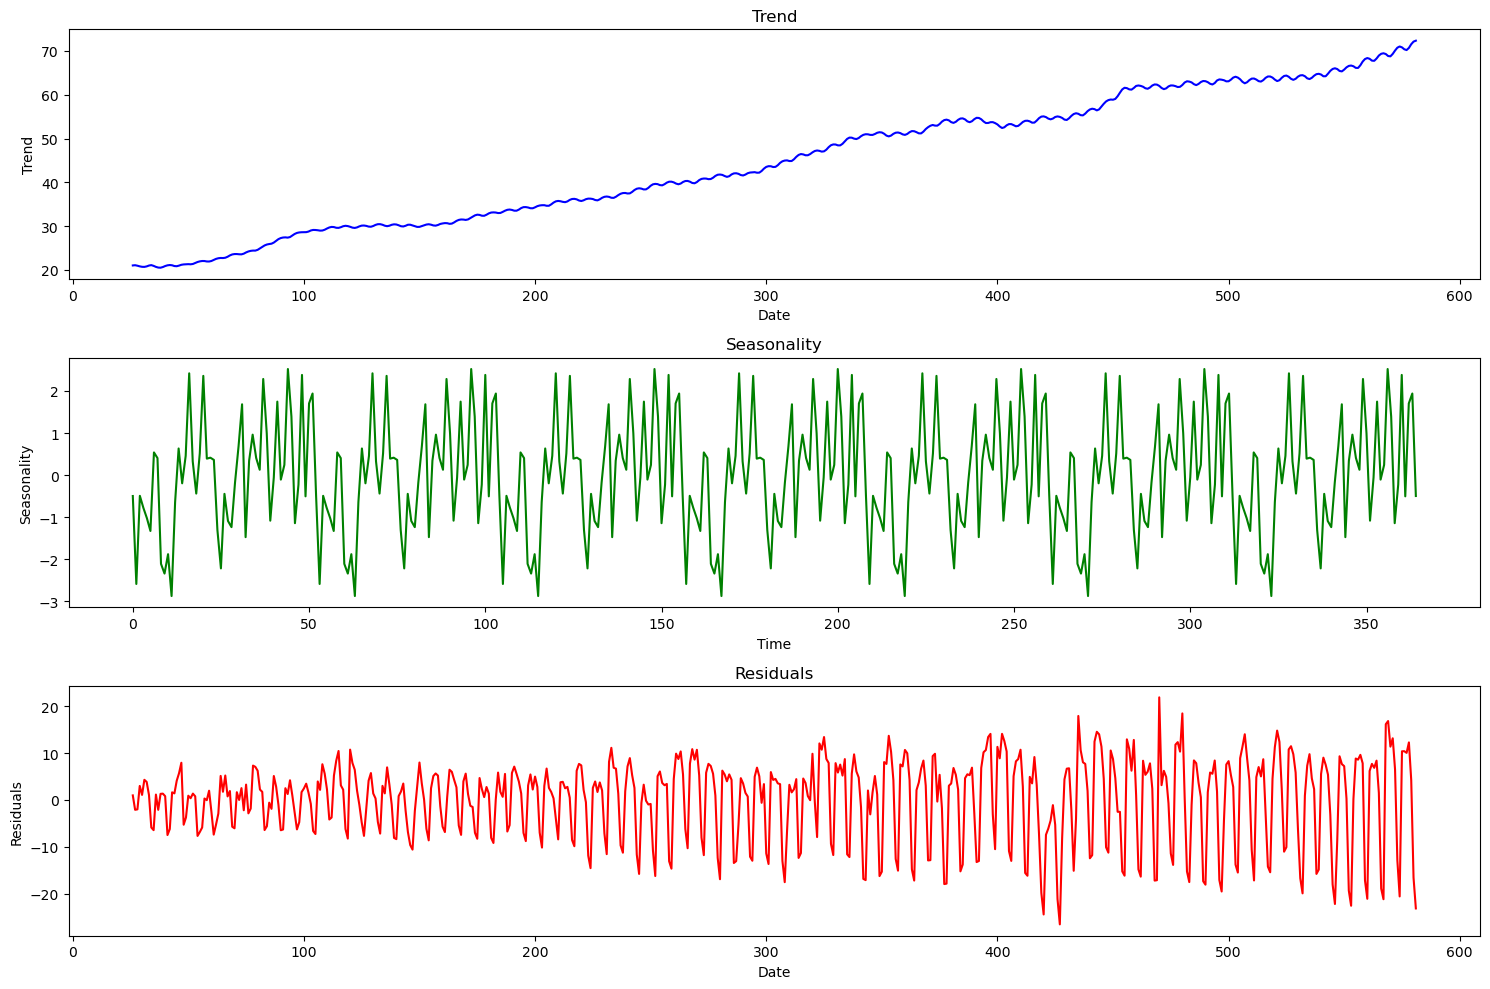

In [15]:
# Perform seasonal decomposition
decomposition_1 = seasonal_decompose(data_junction_1['Vehicles'], period=52) 
plt.figure(figsize=[15, 10])

# Trend
plt.subplot(311)
plt.plot(data_junction_1.index, decomposition_1.trend, label='Trend', color='blue')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.title('Trend')

# Plot a single season
plt.subplot(312)
plt.plot(data_junction_1.index[:365], decomposition_1.seasonal[:365], label='Seasonality', color='green')  
plt.xlabel('Time')
plt.ylabel('Seasonality')
plt.title('Seasonality')

# Residuals
plt.subplot(313)
plt.plot(data_junction_1.index, decomposition_1.resid, label='Residuals', color='red')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals')

plt.tight_layout()
plt.show()


For junction 1, our observations are as follows:

- **Trend or Cycle**: There is an evident increasing trend present in the data. To address this trend, we should consider applying first-order differencing (difference 1) to remove it.

- **Seasonality**: Yes, there is seasonality in the data with a periodicity of 52, indicating a weekly pattern.

- **Volatility**: There is an increasing volatility trend observed. To stabilize the volatility, it's advisable to apply a logarithmic transformation (take log) to the urately.

#### Junction 2

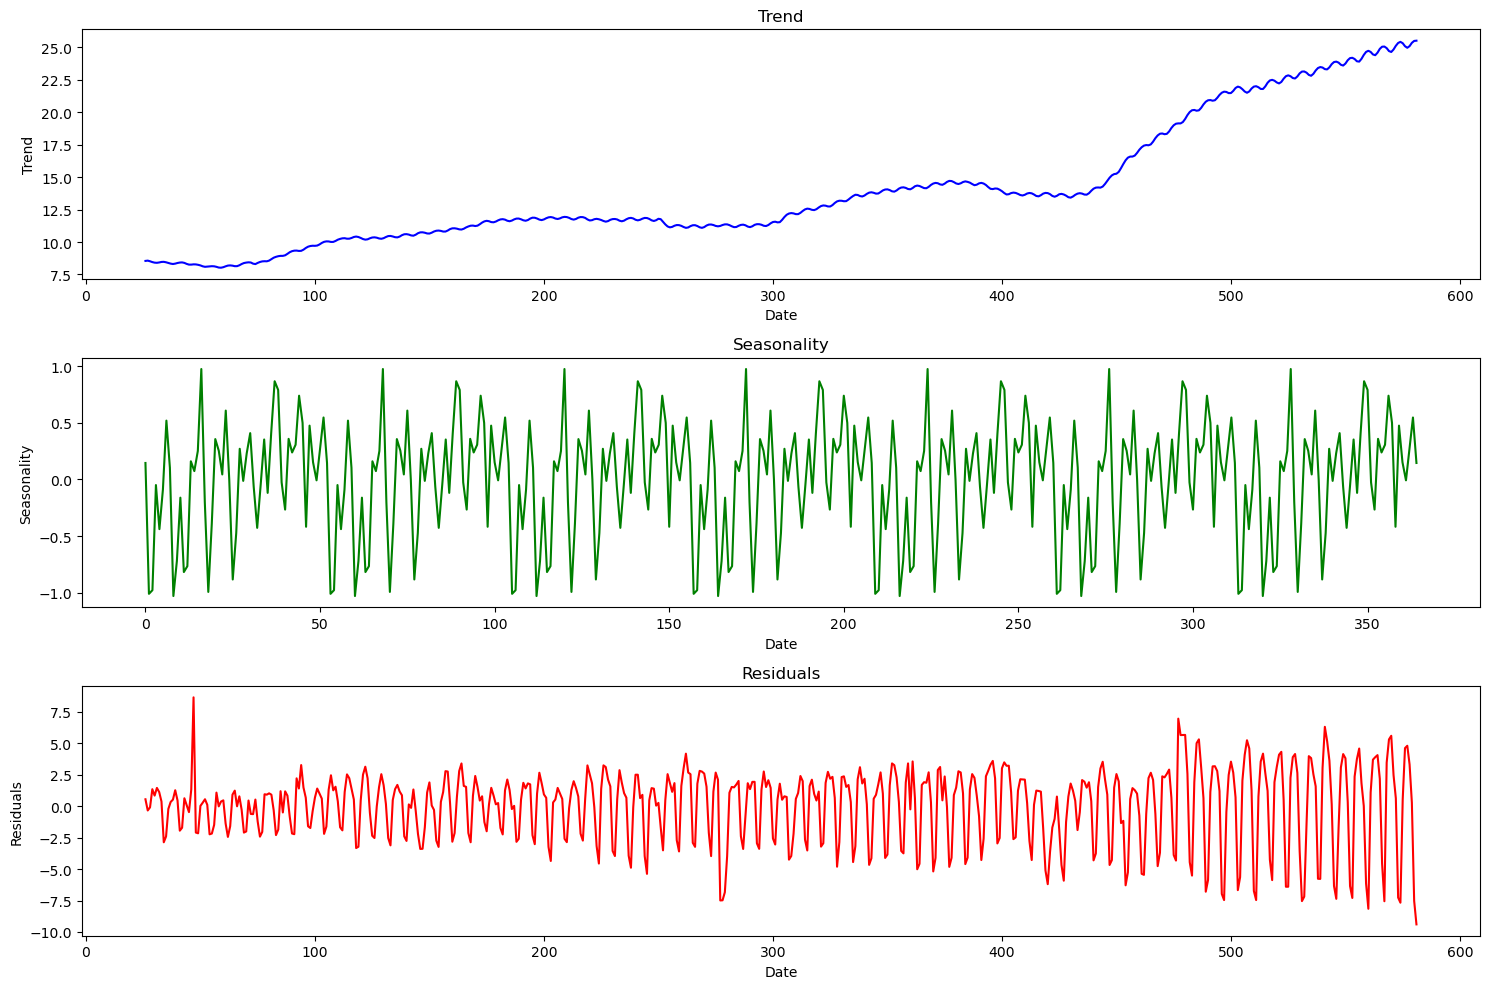

In [16]:
decomposition_2 = seasonal_decompose(data_junction_2['Vehicles'], period=52) 

plt.figure(figsize=[15, 10])

# Trend
plt.subplot(311)
plt.plot(data_junction_2.index, decomposition_2.trend, label='Trend', color='blue')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.title('Trend')

# Seasonality
plt.subplot(312)
plt.plot(data_junction_2.index[:365], decomposition_2.seasonal[:365], label='Seasonality', color='green')
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.title('Seasonality')

# Residuals
plt.subplot(313)
plt.plot(data_junction_2.index, decomposition_2.resid, label='Residuals', color='red')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals')

plt.tight_layout()
plt.show()

For junction 2, our observations are similar to junction 1:

- **Trend or Cycle**: There is a discernible increasing trend in the data. To address this trend, we should consider applying first-order differencing (difference 1).

- **Seasonality**: Yes, the data exhibits seasonality with a periodicity of 52, indicating a weekly pattern.

- **Volatility**: Similar to junction 1, there is an increasing volatility trend observed in the data. Applying a logarithmic transformation (take log) can help stabilize the volatility tynamics.

#### Junction 3

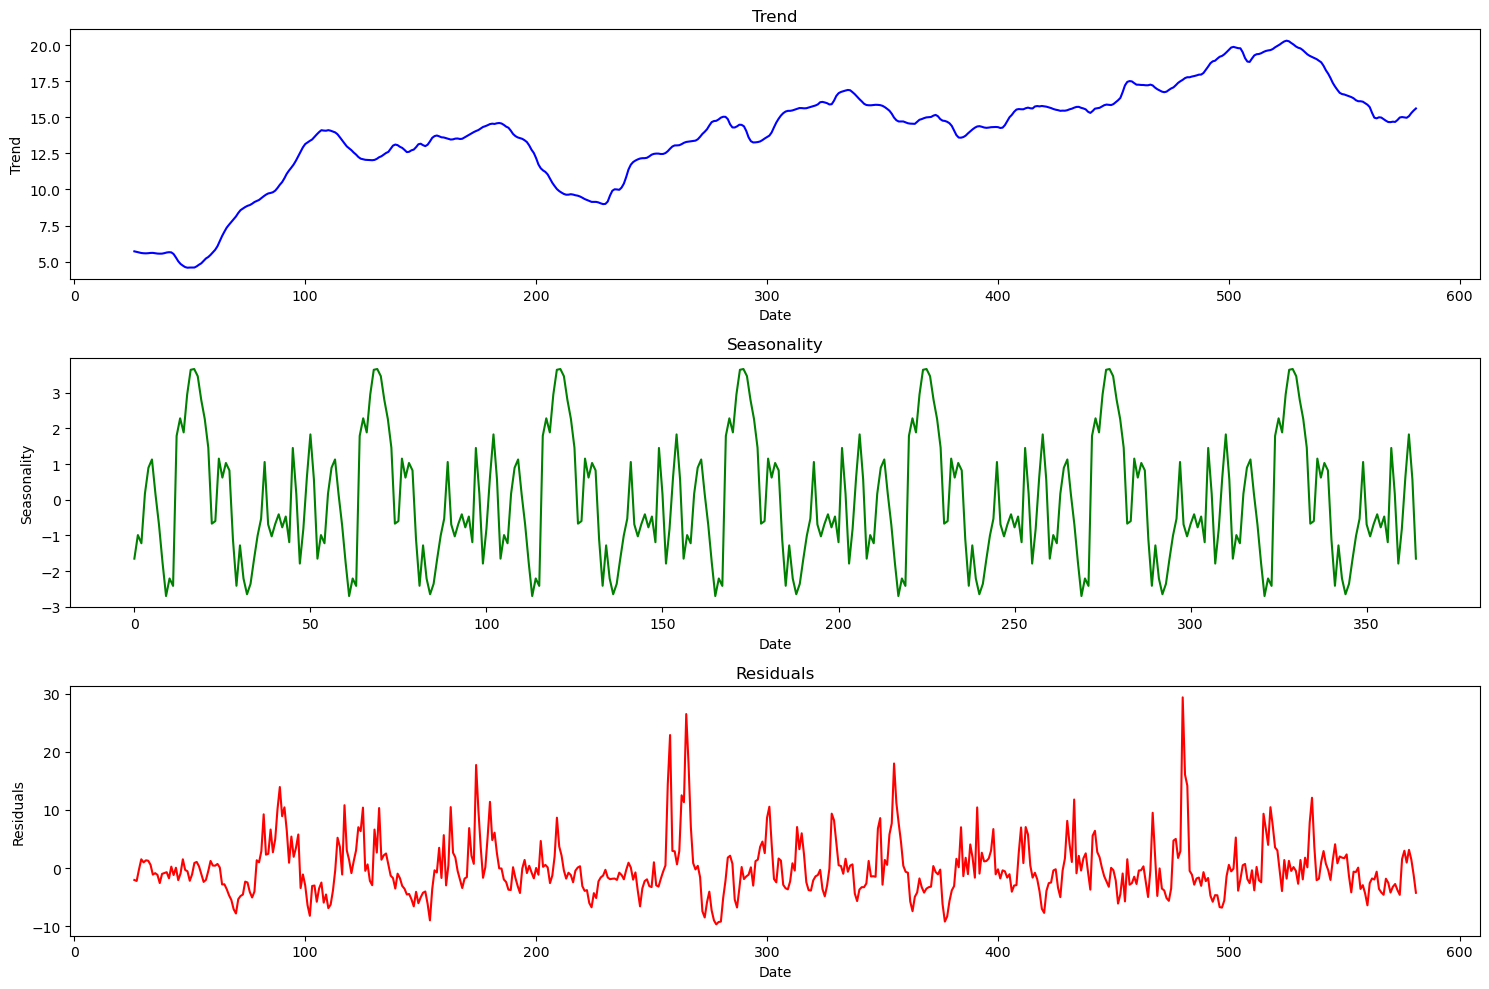

In [17]:
decomposition_3 = seasonal_decompose(data_junction_3['Vehicles'], period=52) 

plt.figure(figsize=[15, 10])

# Trend
plt.subplot(311)
plt.plot(data_junction_3.index, decomposition_3.trend, label='Trend', color='blue')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.title('Trend')

# Seasonality
plt.subplot(312)
plt.plot(data_junction_3.index[:365], decomposition_3.seasonal[:365], label='Seasonality', color='green')
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.title('Seasonality')

# Residuals
plt.subplot(313)
plt.plot(data_junction_3.index, decomposition_3.resid, label='Residuals', color='red')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals')

plt.tight_layout()
plt.show()

For junction 3, our observations are as follows:

- **Trend or Cycle**: While there isn't a clear increasing or decreasing trend, we observe some cyclical patterns in the data, with noticeable oscillations over time.

- **Seasonality**: Although there appears to be some indication of weekly seasonality, further analysis, particularly autocorrelation analysis, may reveal that it is not as pronounced as initially perceived.

- **Volatility**: The volatility in junction 3 data appears to be relatively stable, without significant increasing or decreasing trynamics.

#### Junction 4

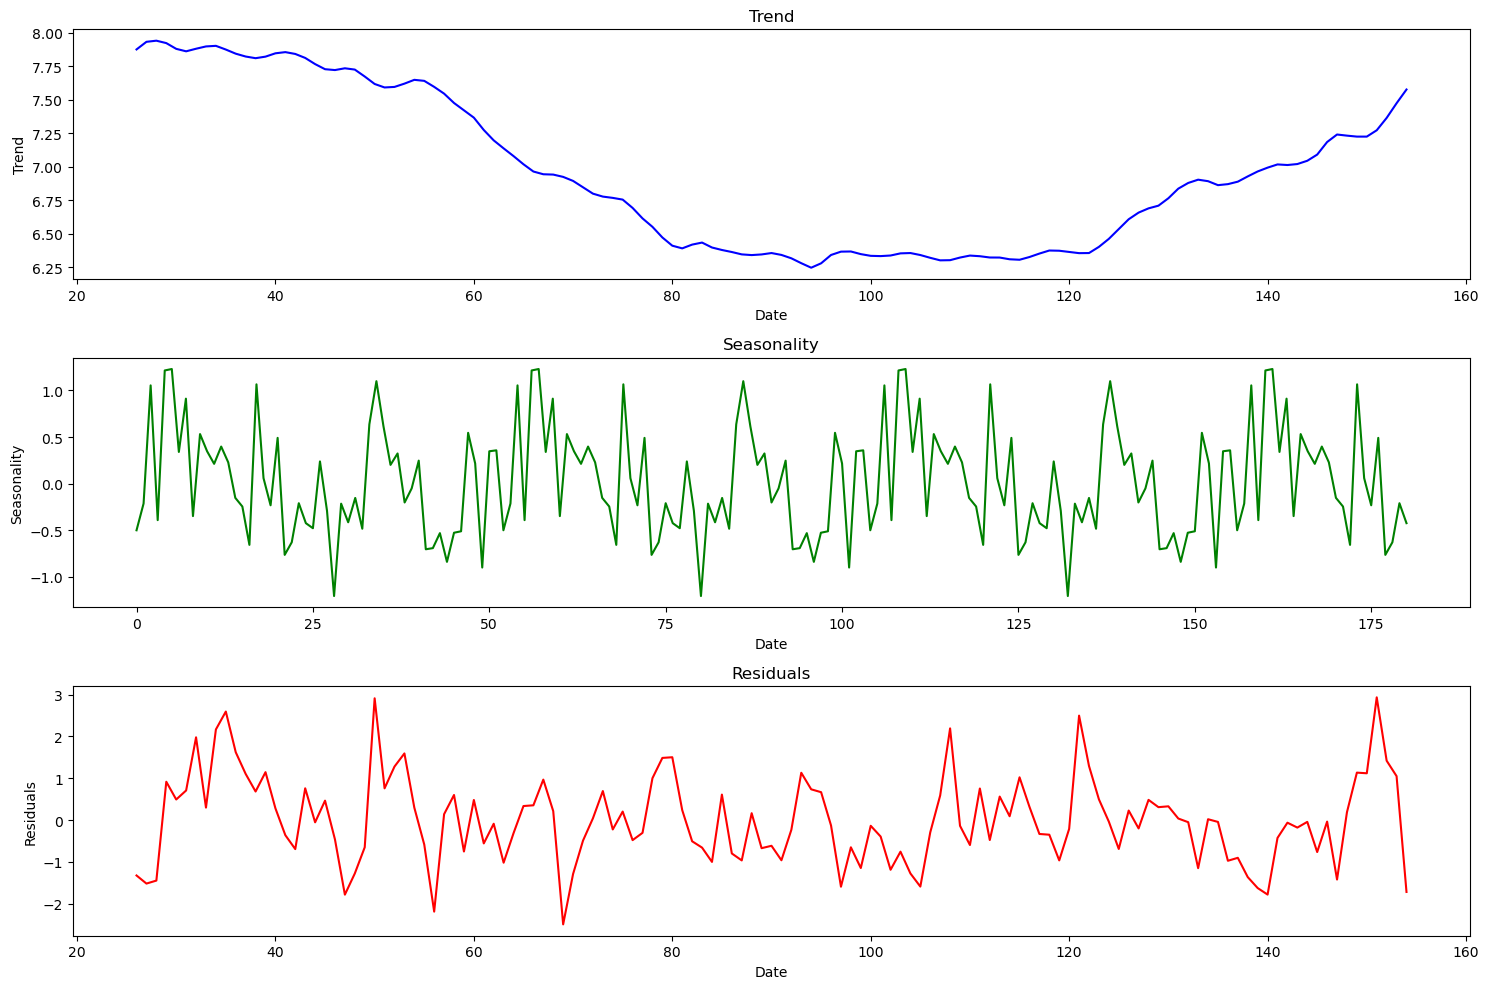

In [18]:
decomposition_4 = seasonal_decompose(data_junction_4['Vehicles'], period=52) 

plt.figure(figsize=[15, 10])

# Trend
plt.subplot(311)
plt.plot(data_junction_4.index, decomposition_4.trend, label='Trend', color='blue')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.title('Trend')

# Seasonality
plt.subplot(312)
plt.plot(data_junction_4.index[:365], decomposition_4.seasonal[:365], label='Seasonality', color='green')
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.title('Seasonality')

# Residuals
plt.subplot(313)
plt.plot(data_junction_4.index, decomposition_4.resid, label='Residuals', color='red')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals')

plt.tight_layout()
plt.show()

For junction 4, our observations are as follows:

- **Trend or Cycle**: There appear to be two potential trends in the data: initially decreasing, followed by increasing. However, before making conclusions about trends, it's imperative to assess stationarity. Additionally, there might be cyclical patterns present in the data, which require further investigation.

- **Seasonality**: It's challenging to ascertain seasonality due to the limited amount of data available for junction 4. However, further analysis and exploration may help uncover any underlying seasonal patterns.

- **Volatility**: The volatility in junction 4 data seems to be relatively stable, without significant fluctuations over time.

Addressing these observations will involve conducting thorough analyses, including stationarity tests and trend assessments, to gain deeper insights into the Time Series dof all our junctions.he data.

## 3. Statistical Analysis:  Augmented Dickey-Fuller Test

The Augmented Dickey-Fuller (ADF) Test serves as a vital statistical tool for assessing the stationarity of a given time series. Stationarity implies that the statistical attributes of a time series, such as its mean and variance, remain consistent over time. By contrast, non-stationarity indicates that these properties vary over time, potentially due to long-term trends or other factors.

The ADF test aids in discerning whether observed changes in the time series are transitory or indicative of enduring trends. Non-stationarity often results in persistent autocorrelation patterns, where observations at different time lags remain correlated. Such patterns pose challenges in modeling and forecasting, as historical trends may not accurately predict future behavior.

Conducting the ADF test across all our time series is crucial to ascertain their stationarity. By confirming stationarity, we can have greater confidence in the decay of autocorrelation and the reliability of our forecasting models. This rigorous assessment ensures that our analyses are built on robust statistical foundations, enhancing the accuracy and effectiveness of our forecasting endeavors.

In [19]:
result1 = adfuller(data_junction_1['Vehicles'])
print('ADF Statistic:', result1[0])
print('p-value 1:', result1[1])

ADF Statistic: -0.3413815102045648
p-value 1: 0.9194355530673952


In [20]:
result2 = adfuller(data_junction_2['Vehicles'])
print('ADF Statistic:', result2[0])
print('p-value 2:', result2[1])

ADF Statistic: 0.4241987866413763
p-value 2: 0.9823776788457992


In [21]:
result3 = adfuller(data_junction_3['Vehicles'])
print('ADF Statistic:', result3[0])
print('p-value 3:', result3[1])

ADF Statistic: -4.5334718108578995
p-value 3: 0.00017099607135022017


In [22]:
result4 = adfuller(data_junction_4['Vehicles'])
print('ADF Statistic:', result4[0])
print('p-value 4:', result4[1])

ADF Statistic: -0.7495829454576868
p-value 4: 0.8334851799444856


In summary, having in mind previous decomposition and the ADF test, the analysis reveals the following observations:

1. **Stable Time Series**: Only the data from junction 3 demonstrates stability without the need for differencing.

2. **Differencing Required**: For junctions 1, 2, and 4, first-order differencing (difference 1) is necessary to address trend or cyclical patterns.

3. **Log Transformation for Noise**: Junctions 1 and 2 exhibit increasing volatility in the noise component. Therefore, applying a logarithmic transformation is recommended to stabilize the volatility trend.

4. **Weekly Seasonality**: junctions 1 and 2 show better a seasonal pattern, while for 3 and 4 is more difficult to discern.


Based on these findings, the next step involves applying the necessary transformations (differencing and log transformation) to the respective time series. Subsequently, we will visualize the transformed data to ensure stationarity and verify the absence of seasonality in the final residuals. This comprehensive analysis will ensure that our time series models are robust and capable of accurate forecasting.

#### Junction 1

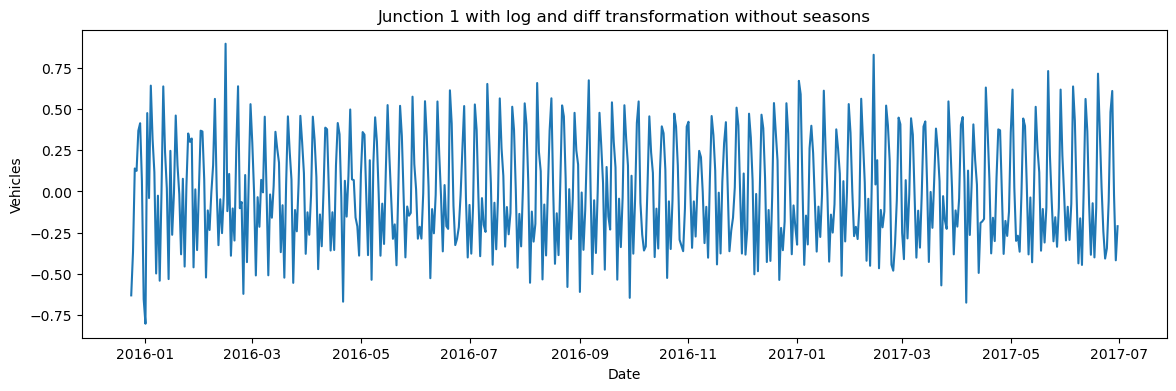

In [23]:
plt.figure(figsize=[14, 4])
plt.plot(data_junction_1['Date'],np.log(data_junction_1['Vehicles']).diff().diff(52))
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.title('Junction 1 with log and diff transformation without seasons')
plt.show()

#### Junction 2

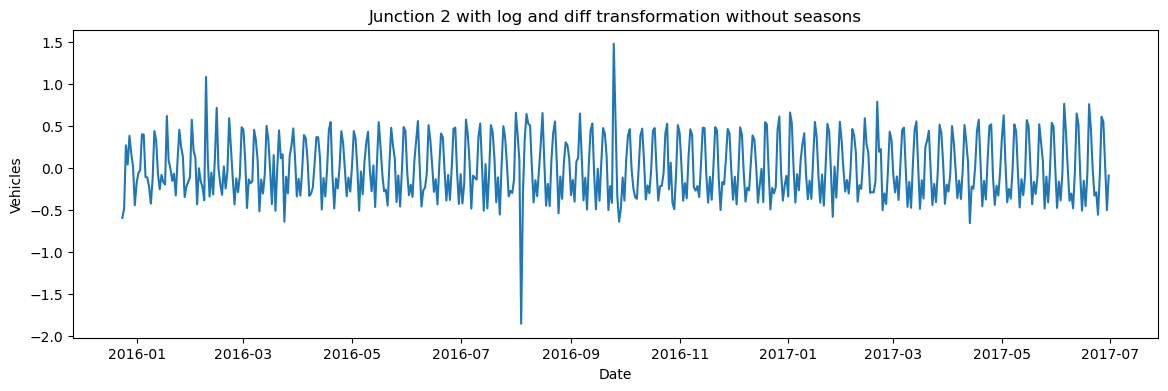

In [24]:
plt.figure(figsize=[14, 4])
plt.plot(data_junction_2['Date'],(np.log(data_junction_2['Vehicles']).diff()).diff(52))
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.title('Junction 2 with log and diff transformation without seasons')
plt.show()

#### Junction 3

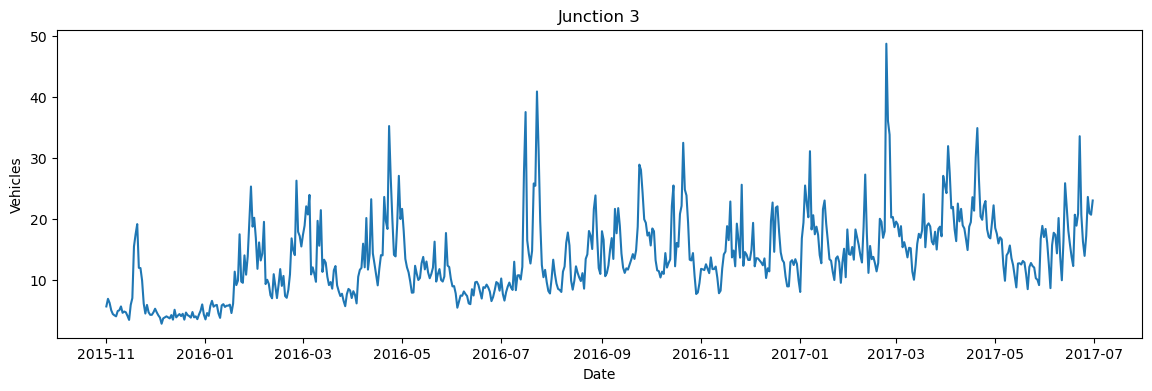

In [25]:
plt.figure(figsize=[14, 4])
plt.plot(data_junction_3['Date'],data_junction_3['Vehicles'])
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.title('Junction 3')
plt.show()

#### Junction 4

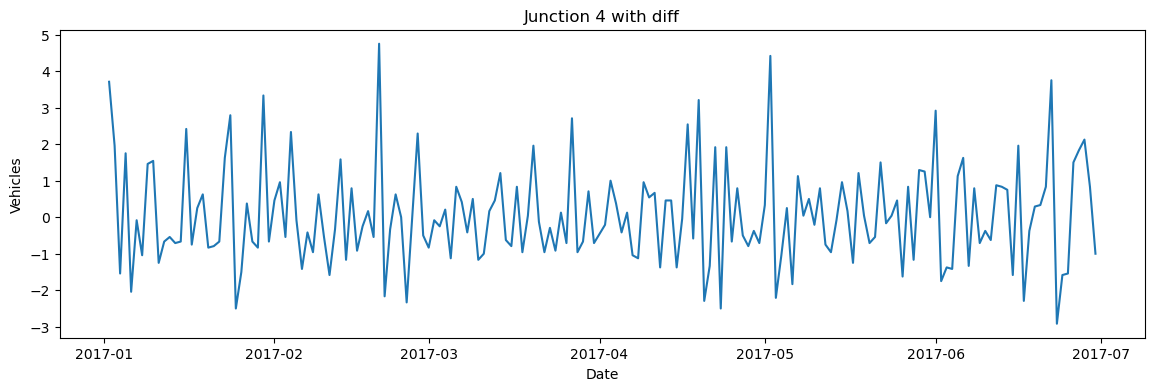

In [26]:
plt.figure(figsize=[14, 4])
plt.plot(data_junction_4['Date'],data_junction_4['Vehicles'].diff())
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.title('Junction 4 with diff')
plt.show()

## 4. Statistical Analysis: Autocorrelation and Partial Autocorrelation Functions

Autocorrelation and partial autocorrelation functions provide insights into the correlation structure of time series data and are essential tools for time series analysis.

- **Autocorrelation Function (ACF)**: The ACF measures the correlation between observations at different time lags. It helps identify patterns in the data where observations are correlated with previous observations at various lags.

- **Partial Autocorrelation Function (PACF)**: The PACF measures the correlation between observations at different time lags while controlling for the influence of intermediate lags. It helps identify the direct relationship between observations at specific lags, excluding the effects of intervening observatin these plots.

Analyzing these patterns will guide us in selecting appropriate ARIMA models for our time series data, taking into account the transformations applied to each dataset.

#### Junction 1

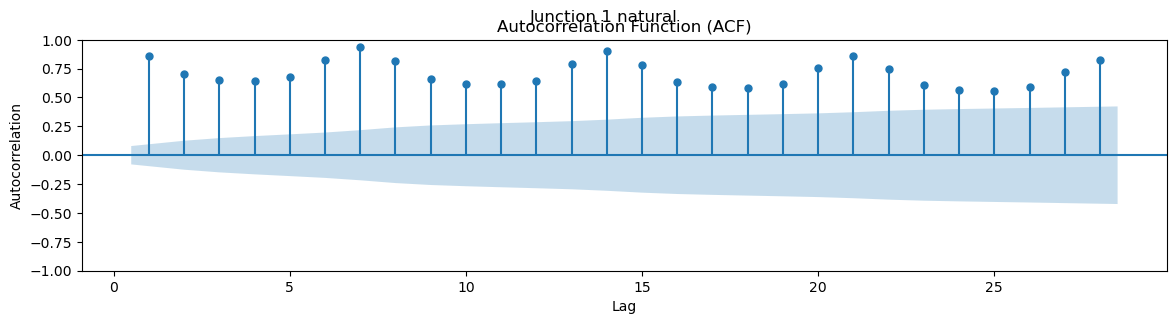

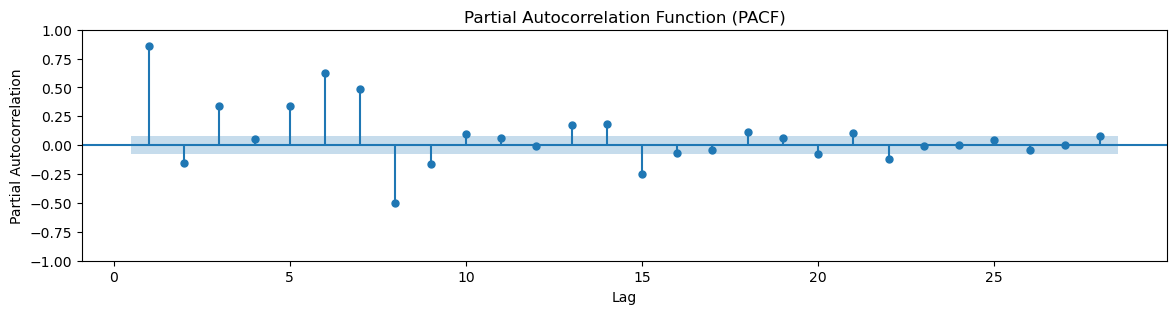

In [27]:
# Plotting Autocorrelation Function (ACF)
plt.figure(figsize=[14, 3])
plt.suptitle('Junction 1 natural ')
plot_acf(data_junction_1['Vehicles'], ax=plt.gca(), zero=False)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plotting Partial Autocorrelation Function (PACF)
plt.figure(figsize=[14, 3])
plot_pacf(data_junction_1['Vehicles'],  ax=plt.gca(), method='ywm', zero=False)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

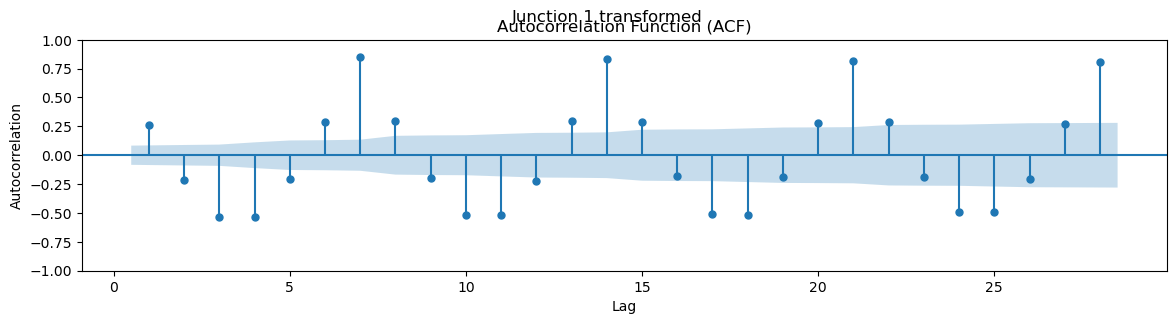

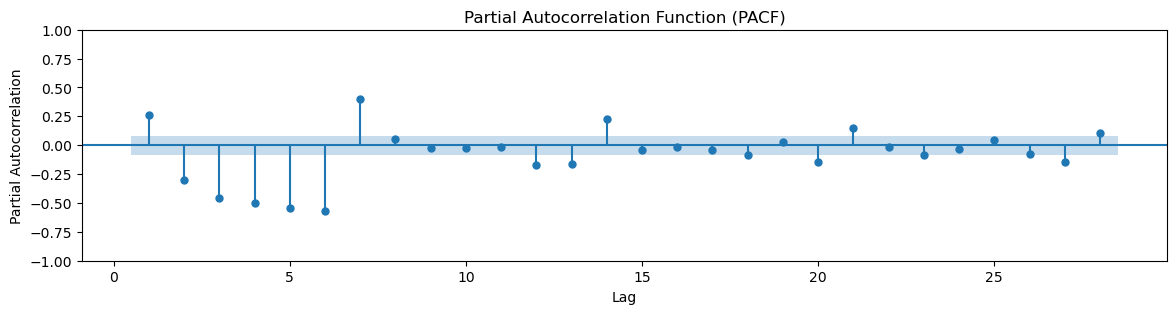

In [28]:
ac_plot_j_1= np.log(data_junction_1['Vehicles']).diff().diff(52).dropna()

# Plotting Autocorrelation Function (ACF)
plt.figure(figsize=[14, 3])
plt.suptitle('Junction 1 transformed')
plot_acf(ac_plot_j_1, ax=plt.gca(), zero=False)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plotting Partial Autocorrelation Function (PACF)
plt.figure(figsize=[14, 3])
plot_pacf(ac_plot_j_1,  ax=plt.gca(), method='ywm', zero=False)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

For junction 1, the deduced models are as follows:

**Regular Model (ARIMA):** The ACF plot does not exhibit significant spikes or a discernible decreasing pattern outside the confidence interval, indicating a lack of strong AR terms. Similarly, the PACF plot shows no prominent spikes, suggesting the absence of strong MA terms. Given the difficulty in determining the regular part, we propose an ARMA(1,1,1) model, where p=1, d=1, and q=1. This model combines autoregressive (AR) and moving average (MA) components to capture the dynamics of the time series data.

**Seasonality Model (SARIMA):** In terms of seasonality, the ACF plot shows prominent bars at the 7th lag, while the PACF exhibits a significant spike at the 7th lag followed by decreasing values. These patterns suggest the presence of a seasonal moving average component (SMA). Therefore, we propose a seasonal ARIMA (SARIMA) model with parameters P=0, D=1 (seasonal differencing), s=52 (weekly seasonality), and Q=1 to account for the seasonal component in the data.

By incorporating both regular and seasonal components into the models, we aim to capture the underlying patterns and dynamics of the junction 1 time series data accurately. These models will facilitate reliable forecasting and analysis of the junction 1 traffic data.

#### Junction 2

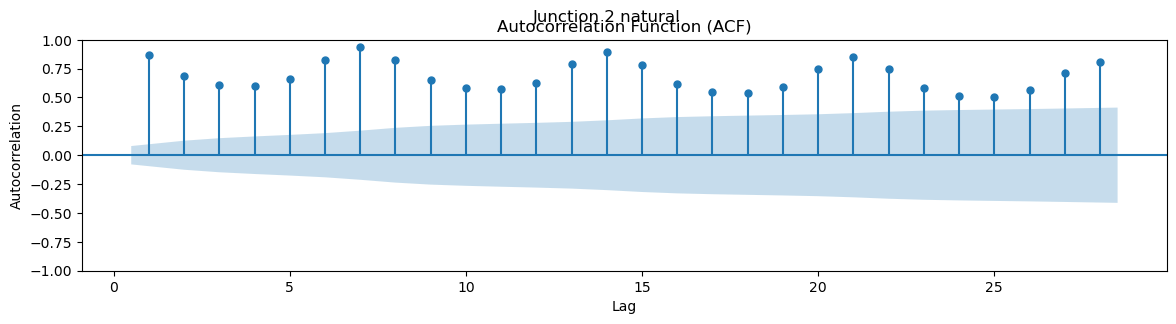

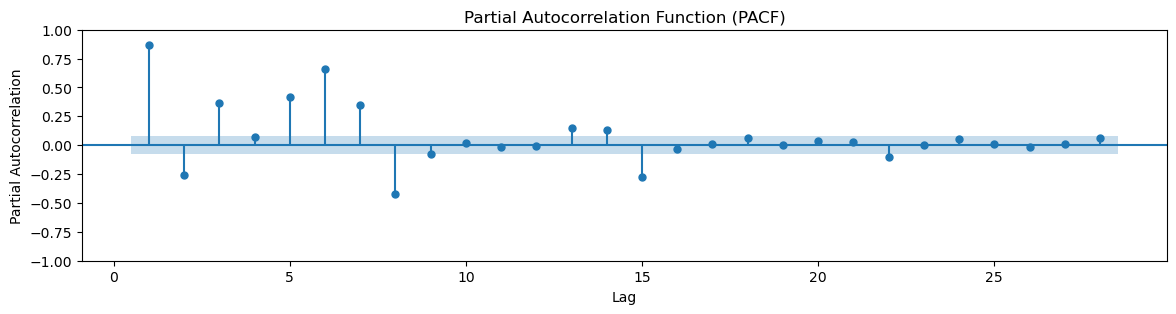

In [29]:
# Plotting Autocorrelation Function (ACF)
plt.figure(figsize=[14, 3])
plt.suptitle('Junction 2 natural')
plot_acf(data_junction_2['Vehicles'], ax=plt.gca(), zero=False)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plotting Partial Autocorrelation Function (PACF)
plt.figure(figsize=[14, 3])
plot_pacf(data_junction_2['Vehicles'],  ax=plt.gca(), method='ywm', zero=False)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

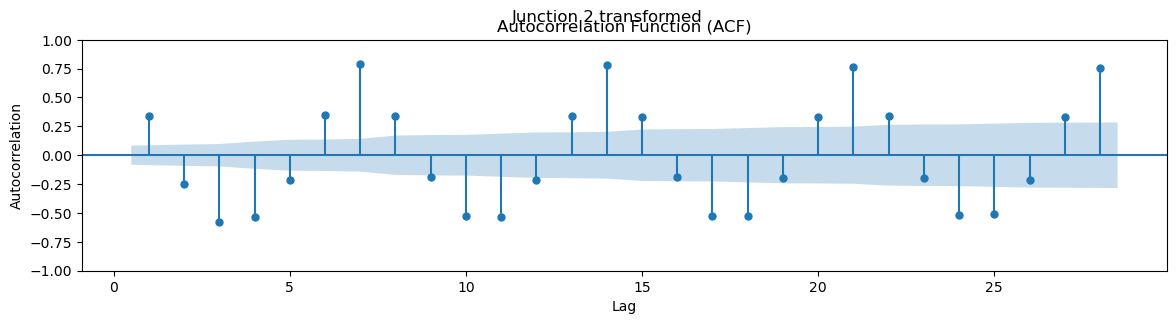

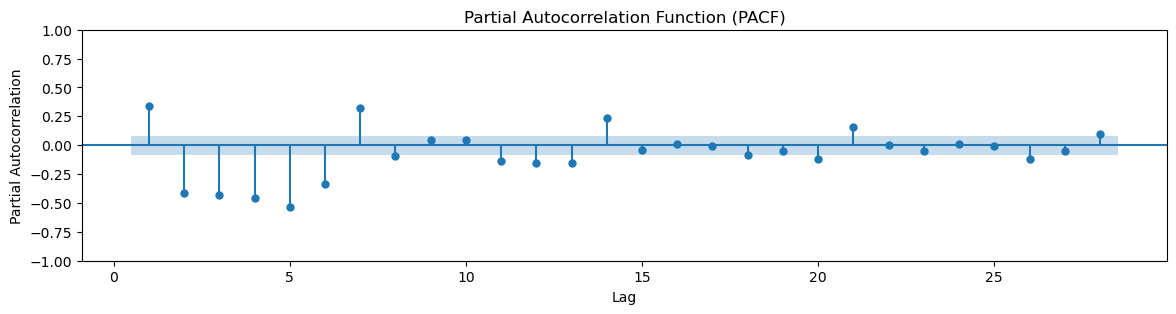

In [30]:
ac_plot_j_2= np.log(data_junction_2['Vehicles']).diff().diff(52).dropna()

# Plotting Autocorrelation Function (ACF)
plt.figure(figsize=[14, 3])
plt.suptitle('Junction 2 transformed')
plot_acf(ac_plot_j_2, ax=plt.gca(), zero=False)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plotting Partial Autocorrelation Function (PACF)
plt.figure(figsize=[14, 3])
plot_pacf(ac_plot_j_2,  ax=plt.gca(), method='ywm', zero=False)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

For junction 2, the deduced models are as follows:

**Regular Model (ARIMA):** Similar to junction 1, the ACF plot for junction 2 does not show significant spikes or a clear decreasing pattern outside the confidence interval. Likewise, the PACF plot suggests the absence of strong MA terms. Hence, we propose an ARMA(1,1) model, incorporating autoregressive and moving average components with parameters p=1, d=1, and q=1.

**Seasonality Model (SARIMA):** Regarding seasonality, the ACF plot indicates prominent bars at the 7th lag, while the PACF exhibits a significant spike at the 7th lag followed by decreasing values, indicating a seasonal moving average (SMA) component. Therefore, we propose a seasonal ARIMA (SARIMA) model with parameters P=0, D=1 (seasonal differencing), s=52 (weekly seasonality), and Q=1 to account for the seasonal patterns in the data.

These models for junction 2 aim to effectively capture the regular and seasonal dynamics inherent in the time series data, facilitating accurate forecasting and analysis of traffic patterns.

#### Junction 3

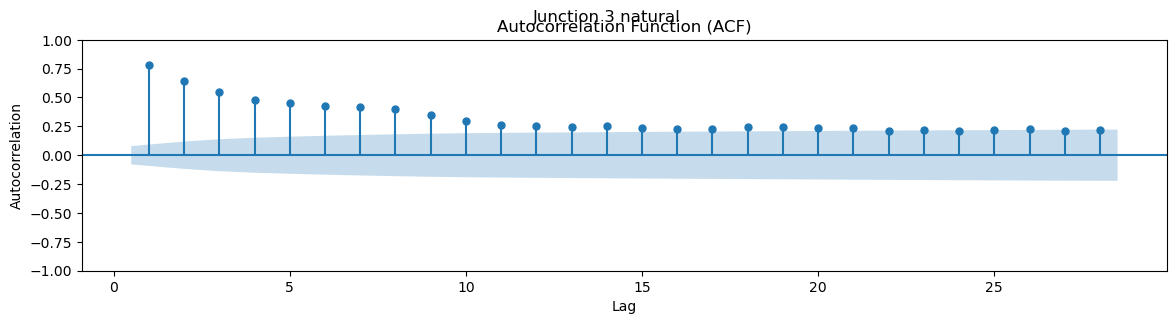

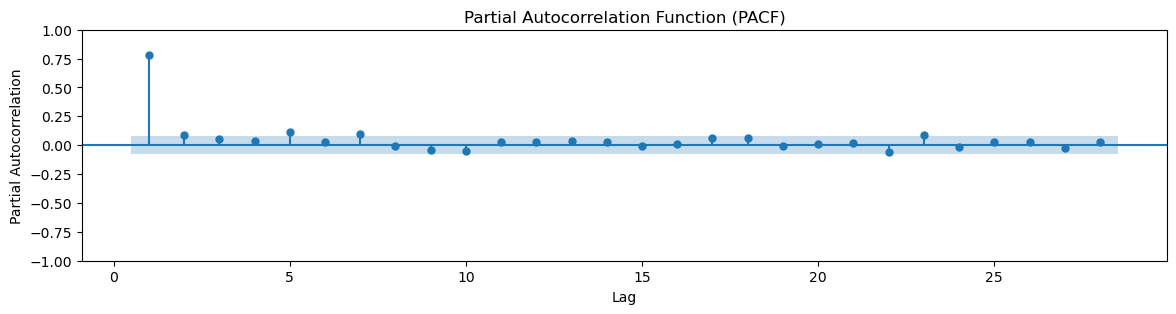

In [31]:
ac_plot_j_3= data_junction_3['Vehicles']
# Plotting Autocorrelation Function (ACF)
plt.figure(figsize=[14, 3])
plt.suptitle('Junction 3 natural')
plot_acf(ac_plot_j_3, ax=plt.gca(), zero=False)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plotting Partial Autocorrelation Function (PACF)
plt.figure(figsize=[14, 3])
plot_pacf(ac_plot_j_3,  ax=plt.gca(), method='ywm', zero=False)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

For junction 3, the deduced models are as follows:

**Regular Model (ARIMA):** Despite the ACF plot not showing a rapid decrease, we trust the results of the Dickey-Fuller test, which indicates stationarity. Therefore, we opt for an AR(1) model without differencing, assuming stability in the time series data.

**Seasonality:** Contrary to the observations made during the time series decomposition, the ACF and PACF plots do not reveal any clear seasonal patterns. This discrepancy may be attributed to various factors, such as the presence of noise or irregularities in the data, which could obscure the underlying seasonaliAs we can remember, junction 3 was the only one with more outliers. ty. Additionally, the seasonal patterns may not be as pronounced in the autocorrelation functions as they appear in the decomposition due to the nature of the statistical tests used and the characteristics of the data.

In summary, for junction 3, we proceed with an AR(1) model for the regular component, while recognizing the absence of clear seasonal patterns based on the ACF and PACF plots. These models will enable us to effectively capture the dynamics of junction 3 traffic data for accurate analysis and forecasting.



#### Junction 4

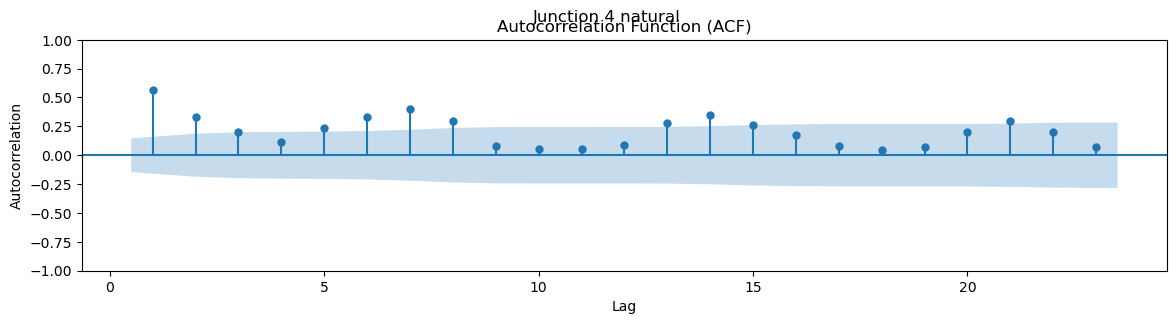

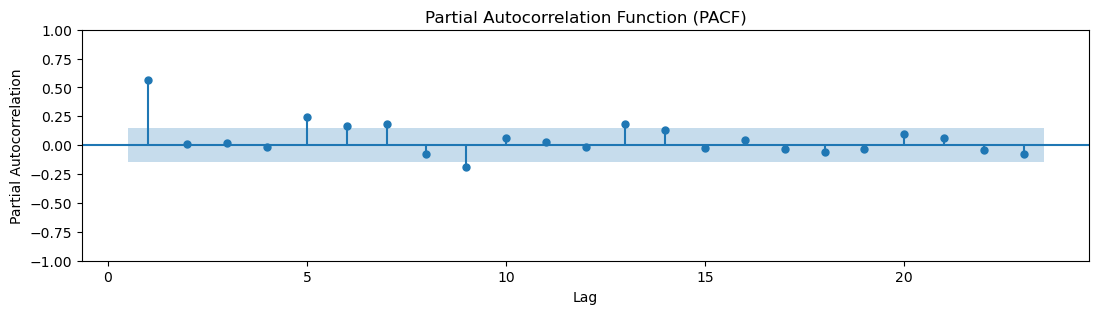

In [32]:
# Plotting Autocorrelation Function (ACF)
plt.figure(figsize=[14, 3])
plt.suptitle('Junction 4 natural')
plot_acf(data_junction_4['Vehicles'], ax=plt.gca(), zero=False)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')

# Plotting Partial Autocorrelation Function (PACF)
plt.figure(figsize=[13, 3])
plot_pacf(data_junction_4['Vehicles'],  ax=plt.gca(), method='ywm', zero=False)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

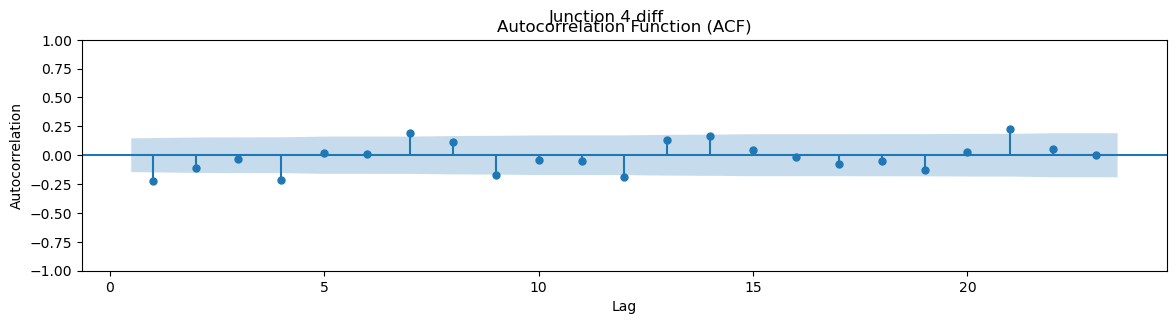

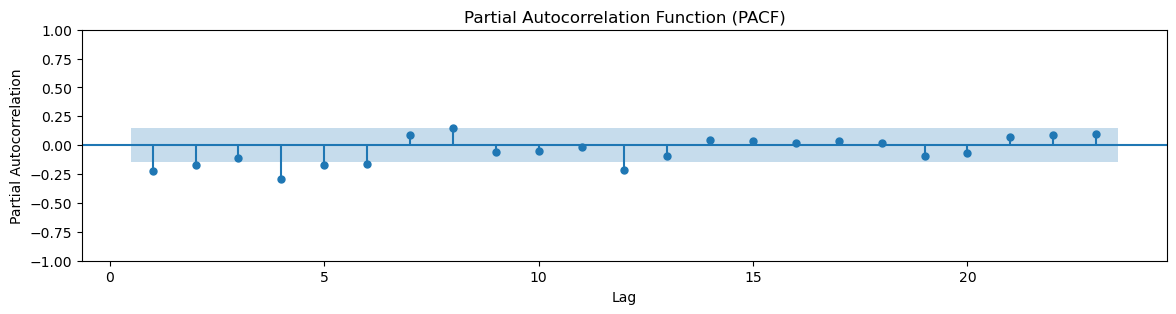

In [33]:
data_junction_4_diff= data_junction_4['Vehicles'].diff().dropna()

plt.figure(figsize=[14, 3])
plt.suptitle('Junction 4 diff')

plot_acf(data_junction_4_diff, ax=plt.gca(), zero=False)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')


# Plotting Partial Autocorrelation Function (PACF)
plt.figure(figsize=[14, 3])
plot_pacf(data_junction_4_diff,  ax=plt.gca(), method='ywm', zero=False)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

For junction 4, the analysis yields the following insights:

**Regular Model (ARIMA):** While the stationarity test suggests the need for differencing, the ACF and PACF plots appear more suitable without it. Notably, the ACF displays a decreasing trend, while the PACF exhibits a significant peak, indicative of an AR(1) process. Thus, we propose an ARIMA(1,1,0) model, incorporating first-order differencing for stationarity and an autoregressive component of order 1.

**Seasonality:** Similarly, there are no discernible seasonal patterns observed in the ACF and PACF plots for junction 4. This absence of seasonality indicates that seasonal adjustments may not be necessary for modeling this particular time series.

In summary, for junction 4, we recommend an ARIMA(1,1,0) model for the regular component, with no adjustments for seasonality. This model configuration aims to capture the underlying dynamics of the junction 4 traffic data accurately for forecasting and analysis purposes.

## 5. Model Selection and forecasting

The primary objective of our project is to identify the best-fitting model for each of our time series datasets. To achieve this goal, we will conduct two different experiments:

1. **Experiment 1:** Utilizing a 4-month window size and implementing 3 sets of train/test data for cross-validation.
2. **Experiment 2:** Employing a 6-month window size and implementing 2-fold cross-validation.

Our focus during these experiments will be on testing accuracy to determine the most suitable model for forecasting purposes. Cross-validation ensures that the results are not biased by the choice of training and testing sets, enhancing the reliability of our findings.

Throughout the experimentation process, we will evaluate various models for each junction, aiming to identify the most appropriate one. However, we will always consider the statistical analyses conducted during the project, particularly the insights gleaned from the ACF and PACF plots, to guide our model selection.

It's important to note that for the last junction, we will not perform cross-validation due to the limited availability of data. Instead, we will rely on the insights gained from the statistical analyses to inform our modeling decisions.

By following this systematic approach, we aim to develop robust forecasting models that accurately capture the dynamics of our time series datasets.

Certainly! Here's the paragraph with the equations formatted using LaTeX:

In our exploration of modeling techniques, we have focused primarily on ARIMA models, which are capable of capturing both autoregressive (AR) and moving average (MA) components, as well as differencing to achieve stationarity. Here's a breakdown of the different types of models within the ARIMA framework:

- **AR Models (Autoregressive Models):** AR models utilize lagged observations as inputs. The order of the AR model, denoted as \( p \), represents the number of lagged observations considered in the model. The AR model equation is as follows:

\[ X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \ldots + \phi_p X_{t-p} + \varepsilon_t \]

where \( X_t \) is the value of the time series at time \( t \), \( c \) is a constant, \( \phi_1, \phi_2, \ldots, \phi_p \) are the autoregressive coefficients, and \( \varepsilon_t \) is the error term at time \( t \).

- **MA Models (Moving Average Models):** MA models utilize lagged errors as inputs. The order of the MA model, denoted as \( q \), represents the number of lagged errors considered in the model. The MA model equation is as follows:

\[ X_t = \mu + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \ldots + \theta_q \varepsilon_{t-q} \]

where \( X_t \) is the value of the time series at time \( t \), \( \mu \) is the mean of the series, \( \varepsilon_t \) is the error term at time \( t \), and \( \theta_1, \theta_2, \ldots, \theta_q \) are the moving average coefficients.

- **ARMA Models (Autoregressive Moving Average Models):** ARMA models combine autoregressive and moving average components. The ARMA model equation is as follows:

\[ X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \ldots + \phi_p X_{t-p} + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \ldots + \theta_q \varepsilon_{t-q} \]

where \( X_t \) is the value of the time series at time \( t \), \( c \) is a constant, \( \phi_1, \phi_2, \ldots, \phi_p \) are the autoregressive coefficients, \( \varepsilon_t \) is the error term at time \( t \), and \( \theta_1, \theta_2, \ldots, \theta_q \) are the moving average coefficients.

- **Integrated Models (ARIMA):** Integrated models involve differencing to make the series stationary. The differencing parameter, denoted as \( d \), represents the number of times the series is differenced. An integrated model follows an ARMA model after differencing. The ARIMA model equation is similar to the ARMA model equation, with \( d \) representing the differencing parameter.

By exploring and selecting from these various models, we can effectively capture the underlying patterns and dynamics present in our time series data for accurate forecasting and analysis.

### 5.1. Train/test split

First, we have defined a function to perform the necesary split for performing cross validation.

In [34]:
def split_data(data, train_window, test_window, num_cv_sets):
    splits = []
    total_days = len(data)

    # Calculate total number of splits
    total_splits = total_days // (train_window + test_window)

    # Generate splits
    for i in range(total_splits):
        start_index = i * (train_window + test_window)
        end_index = start_index + train_window + test_window
        train_indices = list(range(start_index, start_index + train_window))
        test_indices = list(range(start_index + train_window, end_index))

        splits.append((train_indices, test_indices))

    # Select subset of splits based on num_cv_sets
    step = total_splits // num_cv_sets
    selected_splits = [splits[i] for i in range(0, len(splits), step)]

    return selected_splits

def indices_to_dataframe(indices):
    data = []
    for i, (train_indices, test_indices) in enumerate(indices, 1):
        data.append({'Cross-Validation Set': i, 'Train Indices': train_indices, 'Test Indices': test_indices})
    df = pd.DataFrame(data)
    return df
    
# Experiment 1 parameters
train_window_exp1 = 4 * 30  # 4 months converted to days
test_window_exp1 = 1 * 30    # 1 month converted to days
num_cv_sets_exp1 = 3    # 3 cross-validation sets

# Experiment 2 parameters
train_window_exp2 = 6 * 30  # 6 months converted to days
test_window_exp2 = 1 * 30    # 1 month converted to days
num_cv_sets_exp2 = 2    # 2 cross-validation sets

# Split data for Experiment 1
exp1_splits = split_data(data_junction_1, train_window_exp1, test_window_exp1, num_cv_sets_exp1)
exp1_splits = indices_to_dataframe(exp1_splits)
# Split data for Experiment 2
exp2_splits = split_data(data_junction_1, train_window_exp2, test_window_exp2, num_cv_sets_exp2)
exp2_splits = indices_to_dataframe(exp2_splits)
exp1_splits


,Cross-Validation Set,Train Indices,Test Indices
0,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[120, 121, 122, 123, 124, 125, 126, 127, 128, ..."
1,2,"[150, 151, 152, 153, 154, 155, 156, 157, 158, ...","[270, 271, 272, 273, 274, 275, 276, 277, 278, ..."
2,3,"[300, 301, 302, 303, 304, 305, 306, 307, 308, ...","[420, 421, 422, 423, 424, 425, 426, 427, 428, ..."
3,4,"[450, 451, 452, 453, 454, 455, 456, 457, 458, ...","[570, 571, 572, 573, 574, 575, 576, 577, 578, ..."


### 5.2. Junction 1

#### Experiment 1: 4 months training window and 3 set cross validation

In [35]:
# CROSS VALIDATION SET 1 
train_indices = exp1_splits.loc[exp1_splits['Cross-Validation Set'] == 1, 'Train Indices'].iloc[0]
test_indices = exp1_splits.loc[exp1_splits['Cross-Validation Set'] == 1, 'Test Indices'].iloc[0]

# Extract the 'Vehicles' column as the input for all models
x_train = data_junction_1.iloc[train_indices]['Vehicles']
x_test = data_junction_1.iloc[test_indices]['Vehicles']

# Define manual models and seasonal orders
natural_orders = [(1, 1, 0), (0, 1, 1), (1, 1, 1), (2, 1, 1), (1, 1, 2)]
seasonal_orders = [(0, 1, 0, 52), (0, 1, 1, 52), (1, 1, 0, 52), (1, 1, 1, 52)]

# Create combinations of natural and seasonal orders
model_combinations = list(product(natural_orders, seasonal_orders))


# Perform automatic model selection using auto_arima
auto_model = auto_arima(x_train, 
                        start_p=0, start_q=0,
                        max_p=2, max_q=2,
                        d=1, max_d=2,
                        seasonal=True, 
                        stepwise=True, # Grid Search
                        suppress_warnings=True, 
                        error_action='ignore', 
                        trace=True,
                        information_criterion='aicc', m=52)  # You can choose 'aic', 'bic', 'hqic', 'oob', or 'aicc'

# Create an empty DataFrame to store the results
exp1_results = pd.DataFrame(columns=['CV set','Model', 'MAE', 'RMSE'])

# Fit and forecast using the fitted auto_arima model
auto_model.fit(x_train)
auto_forecast, auto_conf_int = auto_model.predict(n_periods=len(x_test), return_conf_int=True)
auto_mae = mean_absolute_error(x_test, auto_forecast)
auto_rmse = np.sqrt(mean_squared_error(x_test, auto_forecast))

# Append results to the DataFrame
exp1_results = pd.concat([exp1_results, pd.DataFrame([[1, 'Auto_ARIMA', auto_mae, auto_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)


# Train ARIMA models for each combination
for i, (natural_order, seasonal_order) in enumerate(model_combinations, start=1):
    # Define model name
    model_name = f'ARIMA{natural_order}_SARIMA{seasonal_order}'
    
    # Fit SARIMA model
    sarima_model = SARIMAX(x_train, order=natural_order, seasonal_order=seasonal_order)
    sarima_fit = sarima_model.fit()
    
    # Forecast
    sarima_forecast = sarima_fit.predict(start=len(x_train), end=len(x_train) + len(x_test) - 1, typ='levels')
    
    # Compute errors
    sarima_mae = mean_absolute_error(x_test, sarima_forecast)
    sarima_rmse = np.sqrt(mean_squared_error(x_test, sarima_forecast))
    
    # Append SARIMA results to DataFrame
    exp1_results = pd.concat([exp1_results, pd.DataFrame([[1, model_name, sarima_mae, sarima_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)


Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AICC=705.304, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AICC=711.543, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AICC=704.118, Time=0.84 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AICC=702.566, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AICC=709.502, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AICC=713.172, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AICC=693.640, Time=2.18 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AICC=691.469, Time=1.19 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AICC=693.640, Time=17.48 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AICC=inf, Time=39.72 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AICC=703.490, Time=0.61 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AICC=inf, Time=3.69 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AICC=inf, Time=2.67 sec
 ARIMA(1,1,2)(1,0,0)[52] intercept   : AICC=inf, Time=3.07 sec
 ARIMA(0,1,1)(1,0,0)[52]        

In [36]:
# CROSS VALIDATION SET 2
warnings.filterwarnings("ignore")
train_indices = exp1_splits.loc[exp1_splits['Cross-Validation Set'] == 2, 'Train Indices'].iloc[0]
test_indices = exp1_splits.loc[exp1_splits['Cross-Validation Set'] == 2, 'Test Indices'].iloc[0]

# Extract the 'Vehicles' column as the input for all models
x_train = data_junction_1.iloc[train_indices]['Vehicles']
x_test = data_junction_1.iloc[test_indices]['Vehicles']

# Perform automatic model selection using auto_arima
auto_model = auto_arima(x_train, 
                        start_p=0, start_q=0,
                        max_p=2, max_q=2,
                        d=1, max_d=2,
                        seasonal=True, 
                        stepwise=True, # Grid Search
                        suppress_warnings=True, 
                        error_action='ignore', 
                        trace=True,
                        information_criterion='aicc',  m=52)  # You can choose 'aic', 'bic', 'hqic', 'oob', or 'aicc'

# Fit and forecast using the fitted auto_arima model
auto_model.fit(x_train)
auto_forecast, auto_conf_int = auto_model.predict(n_periods=len(x_test), return_conf_int=True)
auto_mae = mean_absolute_error(x_test, auto_forecast)
auto_rmse = np.sqrt(mean_squared_error(x_test, auto_forecast))

# Append results to the DataFrame
exp1_results = pd.concat([exp1_results, pd.DataFrame([[2, 'Auto_ARIMA', auto_mae, auto_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)

# Train ARIMA models for each combination
for i, (natural_order, seasonal_order) in enumerate(model_combinations, start=1):
    # Define model name
    model_name = f'ARIMA{natural_order}_SARIMA{seasonal_order}'
    
    # Fit SARIMA model
    sarima_model = SARIMAX(x_train, order=natural_order, seasonal_order=seasonal_order)
    sarima_fit = sarima_model.fit()
    
    # Forecast
    sarima_forecast = sarima_fit.predict(start=len(x_train), end=len(x_train) + len(x_test) - 1, typ='levels')
    
    # Compute errors
    sarima_mae = mean_absolute_error(x_test, sarima_forecast)
    sarima_rmse = np.sqrt(mean_squared_error(x_test, sarima_forecast))
    
    # Append SARIMA results to DataFrame
    exp1_results = pd.concat([exp1_results, pd.DataFrame([[2, model_name, sarima_mae, sarima_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)


Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AICC=inf, Time=2.71 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AICC=809.161, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AICC=813.157, Time=0.80 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AICC=810.505, Time=1.14 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AICC=807.107, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AICC=811.186, Time=0.50 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AICC=811.191, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AICC=811.024, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AICC=809.055, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AICC=800.277, Time=0.11 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AICC=802.334, Time=1.43 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AICC=802.341, Time=1.46 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AICC=inf, Time=3.96 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AICC=inf, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[52] inter

In [37]:
warnings.filterwarnings("ignore")
train_indices = exp1_splits.loc[exp1_splits['Cross-Validation Set'] == 3, 'Train Indices'].iloc[0]
test_indices = exp1_splits.loc[exp1_splits['Cross-Validation Set'] == 3, 'Test Indices'].iloc[0]

# Extract the 'Vehicles' column as the input for all models
x_train = data_junction_1.iloc[train_indices]['Vehicles']
x_test = data_junction_1.iloc[test_indices]['Vehicles']

# Perform automatic model selection using auto_arima
auto_model = auto_arima(x_train, 
                        start_p=0, start_q=0,
                        max_p=2, max_q=2,
                        d=1, max_d=2,
                        seasonal=True, 
                        stepwise=True, # Grid Search
                        suppress_warnings=True, 
                        error_action='ignore', 
                        trace=True,
                        information_criterion='aicc',  m=52)  # You can choose 'aic', 'bic', 'hqic', 'oob', or 'aicc'

# Fit and forecast using the fitted auto_arima model
auto_model.fit(x_train)
auto_forecast, auto_conf_int = auto_model.predict(n_periods=len(x_test), return_conf_int=True)
auto_mae = mean_absolute_error(x_test, auto_forecast)
auto_rmse = np.sqrt(mean_squared_error(x_test, auto_forecast))

# Append results to the DataFrame
exp1_results = pd.concat([exp1_results, pd.DataFrame([[3, 'Auto_ARIMA', auto_mae, auto_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)

# Train ARIMA models for each combination
for i, (natural_order, seasonal_order) in enumerate(model_combinations, start=1):
    # Define model name
    model_name = f'ARIMA{natural_order}_SARIMA{seasonal_order}'
    
    # Fit SARIMA model
    sarima_model = SARIMAX(x_train, order=natural_order, seasonal_order=seasonal_order)
    sarima_fit = sarima_model.fit()
    
    # Forecast
    sarima_forecast = sarima_fit.predict(start=len(x_train), end=len(x_train) + len(x_test) - 1, typ='levels')
    
    # Compute errors
    sarima_mae = mean_absolute_error(x_test, sarima_forecast)
    sarima_rmse = np.sqrt(mean_squared_error(x_test, sarima_forecast))
    
    # Append SARIMA results to DataFrame
    exp1_results = pd.concat([exp1_results, pd.DataFrame([[3, model_name, sarima_mae, sarima_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)


Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AICC=inf, Time=2.42 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AICC=882.572, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AICC=885.071, Time=0.87 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AICC=885.232, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AICC=880.504, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AICC=882.938, Time=0.63 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AICC=883.098, Time=0.69 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AICC=884.413, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AICC=883.960, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AICC=inf, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[52]          
Total fit time: 5.885 seconds


In [38]:
# Group by the 'Model' column
model_group = exp1_results.groupby('Model')

# Calculate the mean of MAE and RMSE for each model
exp1_results = model_group[['MAE', 'RMSE']].mean()

# Print the mean metrics
exp1_results


,MAE,RMSE
Model,,
"ARIMA(0, 1, 1)_SARIMA(0, 1, 0, 52)",18.197398,21.555490
"ARIMA(0, 1, 1)_SARIMA(0, 1, 1, 52)",12.932058,15.375493
"ARIMA(0, 1, 1)_SARIMA(1, 1, 0, 52)",12.082214,14.447702
"ARIMA(0, 1, 1)_SARIMA(1, 1, 1, 52)",12.082129,14.447612
"ARIMA(1, 1, 0)_SARIMA(0, 1, 0, 52)",18.892821,22.237904
"ARIMA(1, 1, 0)_SARIMA(0, 1, 1, 52)",13.079421,15.509432
"ARIMA(1, 1, 0)_SARIMA(1, 1, 0, 52)",12.041785,14.402054
"ARIMA(1, 1, 0)_SARIMA(1, 1, 1, 52)",12.041802,14.402063
"ARIMA(1, 1, 1)_SARIMA(0, 1, 0, 52)",18.743970,22.119450


#### Experiment 2: 6 months training window and 2 set cross validation

In [39]:
# CROSS VALIDATION SET 1 
# Create an empty DataFrame to store the results
exp2_results = pd.DataFrame(columns=['CV set','Model', 'MAE', 'RMSE'])

train_indices = exp2_splits.loc[exp2_splits['Cross-Validation Set'] == 1, 'Train Indices'].iloc[0]
test_indices = exp2_splits.loc[exp2_splits['Cross-Validation Set'] == 1, 'Test Indices'].iloc[0]

# Extract the 'Vehicles' column as the input for all models
x_train = data_junction_1.iloc[train_indices]['Vehicles']
x_test = data_junction_1.iloc[test_indices]['Vehicles']

# Perform automatic model selection using auto_arima
auto_model = auto_arima(x_train, 
                        start_p=0, start_q=0,
                        max_p=2, max_q=2,
                        d=1, max_d=2,
                        seasonal=True, 
                        stepwise=True, # Grid Search
                        suppress_warnings=True, 
                        error_action='ignore', 
                        trace=True,
                        information_criterion='aicc',  m=52)  

# Fit and forecast using the fitted auto_arima model
auto_model.fit(x_train)
auto_forecast, auto_conf_int = auto_model.predict(n_periods=len(x_test), return_conf_int=True)
auto_mae = mean_absolute_error(x_test, auto_forecast)
auto_rmse = np.sqrt(mean_squared_error(x_test, auto_forecast))

# Append results to the DataFrame
exp2_results = pd.concat([exp2_results, pd.DataFrame([[1, 'Auto_ARIMA', auto_mae, auto_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)

# Train ARIMA models for each combination
for i, (natural_order, seasonal_order) in enumerate(model_combinations, start=1):
    # Define model name
    model_name = f'ARIMA{natural_order}_SARIMA{seasonal_order}'
    
    # Fit SARIMA model
    sarima_model = SARIMAX(x_train, order=natural_order, seasonal_order=seasonal_order)
    sarima_fit = sarima_model.fit()
    
    # Forecast
    sarima_forecast = sarima_fit.predict(start=len(x_train), end=len(x_train) + len(x_test) - 1, typ='levels')
    
    # Compute errors
    sarima_mae = mean_absolute_error(x_test, sarima_forecast)
    sarima_rmse = np.sqrt(mean_squared_error(x_test, sarima_forecast))
    
    # Append SARIMA results to DataFrame
    exp2_results = pd.concat([exp2_results, pd.DataFrame([[1, model_name, sarima_mae, sarima_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)


Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AICC=inf, Time=3.45 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AICC=1097.698, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AICC=1095.557, Time=1.02 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AICC=1063.005, Time=1.74 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AICC=1095.756, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AICC=1099.504, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AICC=inf, Time=4.38 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AICC=inf, Time=32.10 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AICC=1053.992, Time=1.82 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AICC=1052.420, Time=24.98 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AICC=inf, Time=71.02 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AICC=1097.191, Time=12.32 sec
 ARIMA(1,1,1)(2,0,0)[52] intercept   : AICC=inf, Time=53.74 sec
 ARIMA(0,1,2)(2,0,0)[52] intercept   : AICC=inf, Time=57.56 sec
 ARIMA(1,1,0)(2,0,0)[52] int

In [40]:
# CROSS VALIDATION SET 2
train_indices = exp2_splits.loc[exp2_splits['Cross-Validation Set'] == 2, 'Train Indices'].iloc[0]
test_indices = exp2_splits.loc[exp2_splits['Cross-Validation Set'] == 2, 'Test Indices'].iloc[0]

# Extract the 'Vehicles' column as the input for all models
x_train = data_junction_1.iloc[train_indices]['Vehicles']
x_test = data_junction_1.iloc[test_indices]['Vehicles']

# Perform automatic model selection using auto_arima
auto_model = auto_arima(x_train, 
                        start_p=0, start_q=0,
                        max_p=2, max_q=2,
                        d=1, max_d=2,
                        seasonal=True, 
                        stepwise=True, # Grid Search
                        suppress_warnings=True, 
                        error_action='ignore', 
                        trace=True,
                        information_criterion='aicc',  m=52)  # You can choose 'aic', 'bic', 'hqic', 'oob', or 'aicc'

# Fit and forecast using the fitted auto_arima model
auto_model.fit(x_train)
auto_forecast, auto_conf_int = auto_model.predict(n_periods=len(x_test), return_conf_int=True)
auto_mae = mean_absolute_error(x_test, auto_forecast)
auto_rmse = np.sqrt(mean_squared_error(x_test, auto_forecast))

# Append results to the DataFrame
exp2_results = pd.concat([exp2_results, pd.DataFrame([[2, 'Auto_ARIMA', auto_mae, auto_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)


# Train ARIMA models for each combination
for i, (natural_order, seasonal_order) in enumerate(model_combinations, start=1):
    # Define model name
    model_name = f'ARIMA{natural_order}_SARIMA{seasonal_order}'
    
    # Fit SARIMA model
    sarima_model = SARIMAX(x_train, order=natural_order, seasonal_order=seasonal_order)
    sarima_fit = sarima_model.fit()
    
    # Forecast
    sarima_forecast = sarima_fit.predict(start=len(x_train), end=len(x_train) + len(x_test) - 1, typ='levels')
    
    # Compute errors
    sarima_mae = mean_absolute_error(x_test, sarima_forecast)
    sarima_rmse = np.sqrt(mean_squared_error(x_test, sarima_forecast))
    
    # Append SARIMA results to DataFrame
    exp2_results = pd.concat([exp2_results, pd.DataFrame([[2, model_name, sarima_mae, sarima_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)

Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AICC=inf, Time=3.41 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AICC=1288.576, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AICC=1290.898, Time=1.25 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AICC=1290.734, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AICC=1286.605, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AICC=1288.813, Time=0.99 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AICC=1288.858, Time=0.96 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AICC=1290.211, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AICC=1289.083, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AICC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[52]          
Total fit time: 8.325 seconds


In [41]:
# Group by the 'Model' column
model_group = exp2_results.groupby('Model')

# Calculate the mean of MAE and RMSE for each model
exp2_results = model_group[['MAE', 'RMSE']].mean()

# Print the mean metrics
exp2_results
results_j1= pd.concat([exp1_results, exp2_results], axis=1)
results_j1

,MAE,RMSE,MAE,RMSE
Model,,,,
"ARIMA(0, 1, 1)_SARIMA(0, 1, 0, 52)",18.197398,21.555490,11.852446,13.829089
"ARIMA(0, 1, 1)_SARIMA(0, 1, 1, 52)",12.932058,15.375493,8.736878,10.191634
"ARIMA(0, 1, 1)_SARIMA(1, 1, 0, 52)",12.082214,14.447702,7.602945,9.298180
"ARIMA(0, 1, 1)_SARIMA(1, 1, 1, 52)",12.082129,14.447612,7.458627,9.151066
"ARIMA(1, 1, 0)_SARIMA(0, 1, 0, 52)",18.892821,22.237904,12.030308,14.009791
"ARIMA(1, 1, 0)_SARIMA(0, 1, 1, 52)",13.079421,15.509432,8.691418,10.131762
"ARIMA(1, 1, 0)_SARIMA(1, 1, 0, 52)",12.041785,14.402054,7.516949,9.177507
"ARIMA(1, 1, 0)_SARIMA(1, 1, 1, 52)",12.041802,14.402063,7.467148,9.197655
"ARIMA(1, 1, 1)_SARIMA(0, 1, 0, 52)",18.743970,22.119450,11.669955,13.702371


The best result from the entire table was obtained with a 6-month x train window using the AutoARIMA method. Overall, Experiment 2 yielded better results, suggesting a 6-month training window for our analysis. 
Our suggested method, ARIMA(1, 1, 1)_SARIMA(0, 1, 1, 52), produced a MAE of 8.285297 and RMSE of 9.754657, which although not the best, is still competitiv 

Thus far, the AutoARIMA method has provided the best result with a MAE of 6.572376 and RMSE of 8.206053. However, other models such as SARIMA(1,1,1)(1,1,1,52) also yield similarly good results.

We will select the best-performing models, in addition to our initial assumption, to visualize the forecast in a single experiment using a 6-month training window and a 1-month test window. During this analysis, we will reevaluate the metrics for both training and testing datasets. The objective is to compare the predictions alongside the actual values to better understand whether the error incurred by each model aligns with the underlying trends and seasonality of the data.

This comprehensive approach will provide insights into the performance of each model and assist in selecting the most suitable one for forecasting purposes.

#### Forecasting visualization

To comprehensively assess the effectiveness of the models we are evaluating, it's essential to compare them with a naive model. In this case, we will incorporate a Seasonal Naive Model, which forecasts the last value from the same season.

For the upcoming analysis and visualization, we will forecast the last month of the dataset using the previous 6 months' data with both the naive models and the top-performing models identified in our previous experiments, including our initial suggestion of a model. We will evaluate both training and test metrics to compare the performance of each model.

By including the Seasonal Naive Model in our analysis, we can establish a baseline for comparison and determine whether the more sophisticated models offer significant improvements in forecasting accuracy over a simpler approach.

This comprehensive approach will provide valuable insights into the relative performance of each model and assist in identifying the most effective forecasting strategy for our dataset.


In [75]:
# Setting train and test windows
test_start = '2017-06-01'
test_start_date = datetime.strptime(test_start, '%Y-%m-%d')
train_start_date = test_start_date - timedelta(days=6*30)  # Restar 6 meses
x_train = data_junction_1[(data_junction_1['Date'] >= train_start_date.strftime('%Y-%m-%d')) & 
                          (data_junction_1['Date'] < test_start)]['Vehicles']
x_test = data_junction_1[data_junction_1['Date'] >= test_start]['Vehicles']

# Seasonal Naive Model: Forecast equals the last value from the same season
seasonal_naive_train_preds = []
seasonal_naive_test_preds = []
for i in range(len(x_train)):
    seasonal_naive_train_preds.append(x_train.iloc[i % 7])  

for i in range(len(x_test)):
    seasonal_naive_test_preds.append(x_train.iloc[i % 7])  

# Calculate MAE and RMSE for Seasonal Naive Model
seasonal_naive_train_mae = mean_absolute_error(x_train, seasonal_naive_train_preds)
seasonal_naive_test_mae = mean_absolute_error(x_test, seasonal_naive_test_preds)
seasonal_naive_train_rmse = np.sqrt(mean_squared_error(x_train, seasonal_naive_train_preds))
seasonal_naive_test_rmse = np.sqrt(mean_squared_error(x_test, seasonal_naive_test_preds))

# Initialize lists to store results
models = ['Seasonal Naive', 'Auto_ARIMA', 'SARIMA(1,1,1)(1,1,1,52)', 'SARIMA(1,1,1)(1,1,0,52)', 'SARIMA(1,1,2)(1,1,1,52)', 'SARIMA(1,1,1)(0,1,1,52)']
train_mae = [seasonal_naive_train_mae]
test_mae = [seasonal_naive_test_mae]
train_rmse = [seasonal_naive_train_rmse]
test_rmse = [seasonal_naive_test_rmse]






In [76]:
# Calculate metrics for Auto_ARIMA
auto_model = auto_arima(x_train, 
                        start_p=0, start_q=0,
                        max_p=2, max_q=2,
                        d=1, max_d=2,
                        seasonal=True, 
                        stepwise=True, # Grid Search
                        suppress_warnings=True, 
                        error_action='ignore', 
                        trace=True,
                        information_criterion='aicc', m=52)  
auto_model.fit(x_train)

auto_train_preds = auto_model.predict_in_sample()
auto_test_preds = auto_model.predict(n_periods=len(x_test))

train_mae.append(mean_absolute_error(x_train, auto_train_preds))
test_mae.append(mean_absolute_error(x_test, auto_test_preds))
train_rmse.append(np.sqrt(mean_squared_error(x_train, auto_train_preds)))
test_rmse.append(np.sqrt(mean_squared_error(x_test, auto_test_preds)))

Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AICC=inf, Time=3.24 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AICC=1408.554, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AICC=1410.489, Time=1.40 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AICC=1409.322, Time=1.59 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AICC=1406.536, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AICC=1408.445, Time=0.85 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AICC=1408.540, Time=1.03 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AICC=1409.922, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AICC=1407.371, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AICC=1394.490, Time=0.13 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AICC=1395.445, Time=2.51 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AICC=1395.365, Time=2.50 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AICC=inf, Time=5.36 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AICC=inf, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0

In [77]:
warnings.filterwarnings("ignore")

# ARIMA(1, 1, 1)_SARIMA(1, 1, 1, 52)
sarima111_model = SARIMAX(x_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima111_fit = sarima111_model.fit()

# ARIMA(1, 1, 1)_SARIMA(1, 1, 0, 52)
sarima110_model = SARIMAX(x_train, order=(1, 1, 1), seasonal_order=(1, 1, 0, 52))
sarima110_fit = sarima110_model.fit()

# ARIMA(1, 1, 2)_SARIMA(1, 1, 1, 52)
sarima121_model = SARIMAX(x_train, order=(1, 1, 2), seasonal_order=(1, 1, 1, 52))
sarima121_fit = sarima121_model.fit()

# ARIMA(1, 1, 1)_SARIMA(0, 1, 1, 52)
sarima120_model = SARIMAX(x_train, order=(1, 1, 1), seasonal_order=(0, 1, 1, 52))
sarima120_fit = sarima120_model.fit()

# Calculate metrics for SARIMA(1,1,1)(1,1,1,52)
sarima111_train_preds = sarima111_fit.predict(typ='levels')
sarima111_test_preds = sarima111_fit.forecast(steps=len(x_test))

train_mae.append(mean_absolute_error(x_train, sarima111_train_preds))
test_mae.append(mean_absolute_error(x_test, sarima111_test_preds))
train_rmse.append(np.sqrt(mean_squared_error(x_train, sarima111_train_preds)))
test_rmse.append(np.sqrt(mean_squared_error(x_test, sarima111_test_preds)))

# Calculate metrics for SARIMA(1,1,1)(1,1,0,52)
sarima110_train_preds = sarima110_fit.predict(typ='levels')
sarima110_test_preds = sarima110_fit.forecast(steps=len(x_test))

train_mae.append(mean_absolute_error(x_train, sarima110_train_preds))
test_mae.append(mean_absolute_error(x_test, sarima110_test_preds))
train_rmse.append(np.sqrt(mean_squared_error(x_train, sarima110_train_preds)))
test_rmse.append(np.sqrt(mean_squared_error(x_test, sarima110_test_preds)))

# Calculate metrics for SARIMA(1,1,2)(1,1,1,52)
sarima121_train_preds = sarima121_fit.predict(typ='levels')
sarima121_test_preds = sarima121_fit.forecast(steps=len(x_test))

train_mae.append(mean_absolute_error(x_train, sarima121_train_preds))
test_mae.append(mean_absolute_error(x_test, sarima121_test_preds))
train_rmse.append(np.sqrt(mean_squared_error(x_train, sarima121_train_preds)))
test_rmse.append(np.sqrt(mean_squared_error(x_test, sarima121_test_preds)))

# Calculate metrics for SARIMA(1,1,2)(1,1,0,52)
sarima120_train_preds = sarima120_fit.predict(typ='levels')
sarima120_test_preds = sarima120_fit.forecast(steps=len(x_test))

train_mae.append(mean_absolute_error(x_train, sarima120_train_preds))
test_mae.append(mean_absolute_error(x_test, sarima120_test_preds))
train_rmse.append(np.sqrt(mean_squared_error(x_train, sarima120_train_preds)))
test_rmse.append(np.sqrt(mean_squared_error(x_test, sarima120_test_preds)))

# Store results in DataFrame
final_results = pd.DataFrame({
    'Model': models,
    'Train_MAE': train_mae,
    'Test_MAE': test_mae,
    'Train_RMSE': train_rmse,
    'Test_RMSE': test_rmse
})

final_results

,Model,Train_MAE,Test_MAE,Train_RMSE,Test_RMSE
0,Seasonal Naive,6.260648,22.205556,8.122853,23.900096
1,Auto_ARIMA,8.933413,9.878610,11.033423,12.236618
2,"SARIMA(1,1,1)(1,1,1,52)",11.660781,15.374458,15.123023,20.902761
3,"SARIMA(1,1,1)(1,1,0,52)",11.090497,13.814957,14.206510,15.671398
4,"SARIMA(1,1,2)(1,1,1,52)",10.346221,14.084667,13.382294,16.159650
5,"SARIMA(1,1,1)(0,1,1,52)",11.645614,17.022587,15.130981,22.437580


It's indeed surprising that the naive model outperformed the other models on the training set, while the AutoARIMA model (ARIMA(2,1,0)(1,0,1)[52]) performed best on the testing set for both metrics. These results may seem unclear solely based on the metrics, highlighting the importance of visualizing the predictions to better understand how each model captures the information within the Time Series data.

Visualization allows us to observe the actual values alongside the predicted values generated by each model. By comparing the patterns, trends, and seasonal variations in the predictions with the actual data, we can gain insights into how well each model captures the underlying dynamics of the Time Serieasets.

In [78]:
# We fit again the auto_arima model manually to be able to plot prediction intervals
auto_model = SARIMAX(x_train, order=(2, 1, 0), seasonal_order=(1, 0, 1, 52))
auto_model = auto_model.fit()

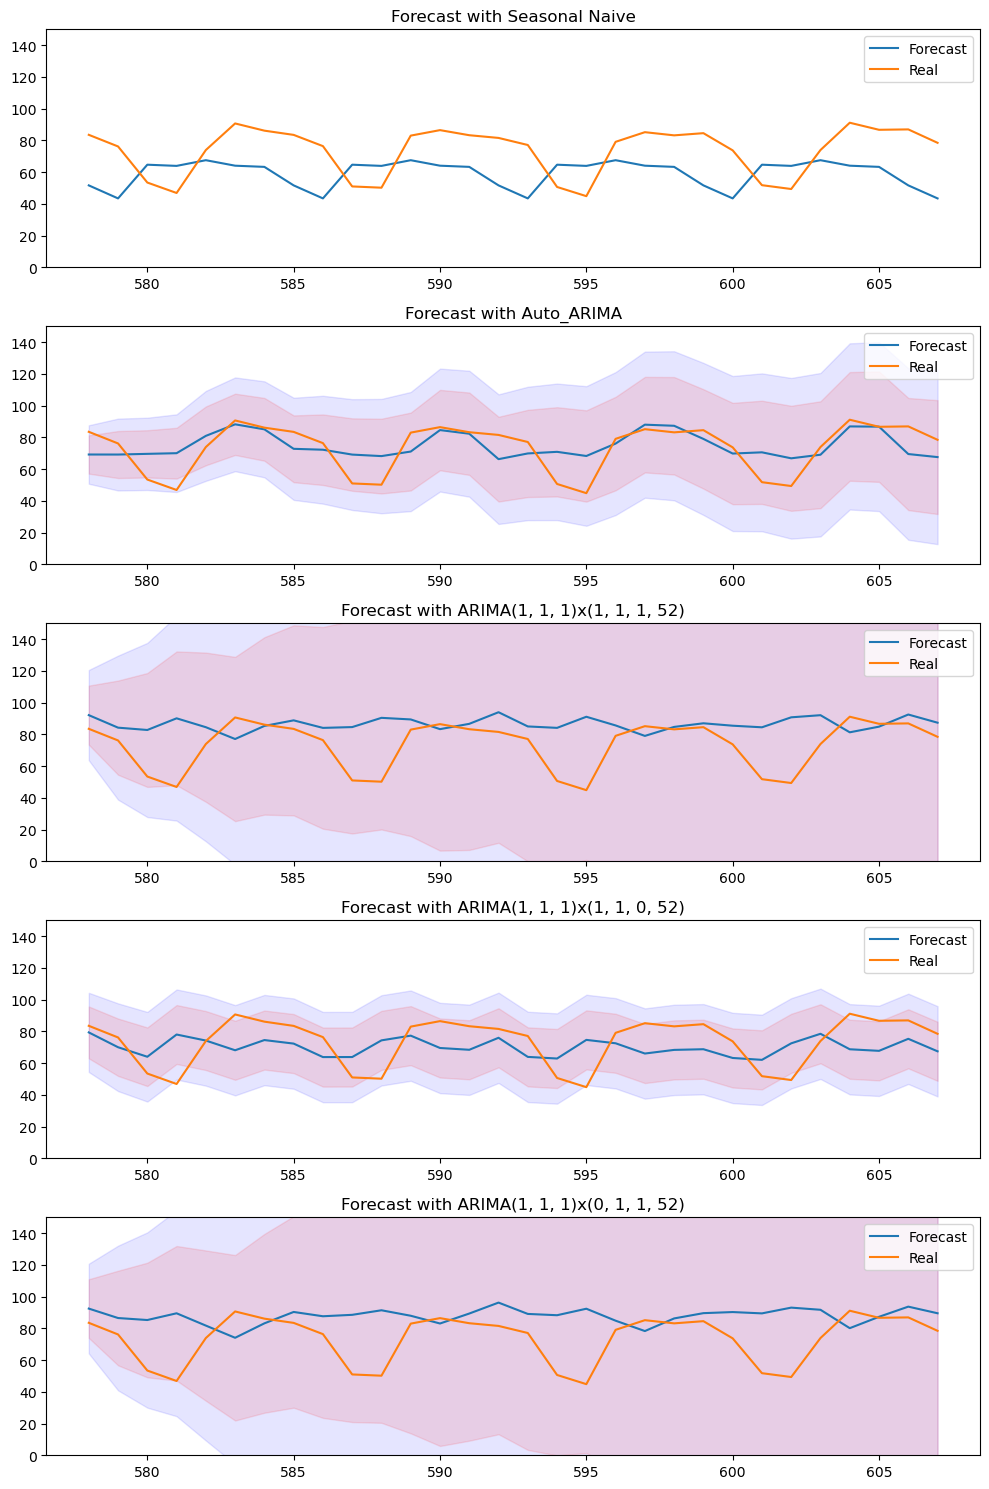

In [79]:
# Create a list of models and their names for iteration
models = [ (seasonal_naive_test_preds, 'Seasonal Naive'),
          (auto_model, 'Auto_ARIMA'), 
          (sarima111_fit, 'ARIMA(1, 1, 1)x(1, 1, 1, 52)'),
          (sarima110_fit, 'ARIMA(1, 1, 1)x(1, 1, 0, 52)'),
          (sarima120_fit, 'ARIMA(1, 1, 1)x(0, 1, 1, 52)')]

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

# Iterate over each model
for ax, (model, name) in zip(axes, models):
    # Make predictions
    if model != seasonal_naive_test_preds: 
        forecast = model.get_forecast(steps=len(x_test)).predicted_mean
        forecast.index = x_test.index
        
        # Plot forecast
        ax.plot(x_test.index, forecast, label='Forecast')
        ax.plot(x_test.index, x_test, label='Real')
        ax.set_title(f'Forecast with {name}')
        ax.legend()
    
        # Plot prediction intervals if available
       
        pred_ci_95= model.get_forecast(steps=len(x_test)).conf_int()#default alpha=0.05 95% CI
        pred_ci_80 = model.get_forecast(steps=len(x_test)).conf_int(alpha=0.2)
    
        ax.fill_between(x_test.index, pred_ci_95.iloc[:, 0], pred_ci_95.iloc[:, 1], color='b', alpha=0.1)
        ax.fill_between(x_test.index, pred_ci_80.iloc[:, 0], pred_ci_80.iloc[:, 1], color='r', alpha=0.1)
    
        # Set y-axis limits
        ax.set_ylim(0, 150)
    else:
        # Plot forecast
        ax.plot(x_test.index, model, label='Forecast')
        ax.plot(x_test.index, x_test, label='Real')
        ax.set_title(f'Forecast with {name}')
        ax.legend()

        ax.set_ylim(0, 150)

# Adjust layout
plt.tight_layout()
plt.show()

Based on the visualization and analysis of the model predictions, several key observations can be made:

- The thi and lastrd modsel exhibits increasing prediction intervals, indicating instability and poor forecasting performanc Futhermore, the last model is the one initially considered as a viable option, which finally fails to adequately capture the data distribution and deliver accurate forecasts, as evidenced by the visualization.e.
- While the naive model may have appeared adequate based on metrics, its inability to track the underlying trends of the data is evident in the visualization, where it demonstrates erratic behavior.
- The AutoARIMA model, ARIMA(2,1,0)(1,0,1)[52], not only performed best according to metrics but also tracks the data trends most accurately in the visualization. Additionally, the prediction intervals for the initial forecasts are smaller compared to other models, although they increase slightly over time, possibly due to increasing uncertainty inherent in longer-term predictiation.

In conclusion, the ARIMA(2,1,0)(1,0,1)[52] model, selected by the AutoARIMA algorithm, emerges as the best choice. This model's parameters indicate an autoregressive component of order 2, a first-order differencing, and a moving average component of order 1, with a seasonal component of order 1 and first-order seasonal differencing, along with a seasonal moving average component of order 1.

By selecting this model, we can confidently leverage its forecasting capabilities to make informed decisions based on the underlying patterns and trends present in the time series data.



### 5.3. Junction 2

#### Experiment 1: 4 months training window and 3 set cross validation

In [47]:
# CROSS VALIDATION SET 1 
train_indices = exp1_splits.loc[exp1_splits['Cross-Validation Set'] == 1, 'Train Indices'].iloc[0]
test_indices = exp1_splits.loc[exp1_splits['Cross-Validation Set'] == 1, 'Test Indices'].iloc[0]

# Extract the 'Vehicles' column as the input for all models
x_train = data_junction_2.iloc[train_indices]['Vehicles']
x_test = data_junction_2.iloc[test_indices]['Vehicles']

# Define manual models and seasonal orders
natural_orders = [(1, 1, 0), (0, 1, 1), (1, 1, 1), (2, 1, 1), (1, 1, 2)]
seasonal_orders = [(0, 1, 0, 52), (0, 1, 1, 52), (1, 1, 0, 52), (1, 1, 1, 52)]

# Create combinations of natural and seasonal orders
model_combinations = list(product(natural_orders, seasonal_orders))


# Perform automatic model selection using auto_arima
auto_model = auto_arima(x_train, 
                        start_p=0, start_q=0,
                        max_p=2, max_q=2,
                        d=1, max_d=2,
                        seasonal=True, 
                        stepwise=True, # Grid Search
                        suppress_warnings=True, 
                        error_action='ignore', 
                        trace=True,
                        information_criterion='aicc', m=52)  # You can choose 'aic', 'bic', 'hqic', 'oob', or 'aicc'

# Create an empty DataFrame to store the results
exp1_results = pd.DataFrame(columns=['CV set','Model', 'MAE', 'RMSE'])

# Fit and forecast using the fitted auto_arima model
auto_model.fit(x_train)
auto_forecast, auto_conf_int = auto_model.predict(n_periods=len(x_test), return_conf_int=True)
auto_mae = mean_absolute_error(x_test, auto_forecast)
auto_rmse = np.sqrt(mean_squared_error(x_test, auto_forecast))

# Append results to the DataFrame
exp1_results = pd.concat([exp1_results, pd.DataFrame([[1, 'Auto_ARIMA', auto_mae, auto_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)


# Train ARIMA models for each combination
for i, (natural_order, seasonal_order) in enumerate(model_combinations, start=1):
    # Define model name
    model_name = f'ARIMA{natural_order}_SARIMA{seasonal_order}'
    
    # Fit SARIMA model
    sarima_model = SARIMAX(x_train, order=natural_order, seasonal_order=seasonal_order)
    sarima_fit = sarima_model.fit()
    
    # Forecast
    sarima_forecast = sarima_fit.predict(start=len(x_train), end=len(x_train) + len(x_test) - 1, typ='levels')
    
    # Compute errors
    sarima_mae = mean_absolute_error(x_test, sarima_forecast)
    sarima_rmse = np.sqrt(mean_squared_error(x_test, sarima_forecast))
    
    # Append SARIMA results to DataFrame
    exp1_results = pd.concat([exp1_results, pd.DataFrame([[1, model_name, sarima_mae, sarima_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)


Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AICC=inf, Time=2.52 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AICC=505.924, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AICC=506.819, Time=0.69 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AICC=479.587, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AICC=503.863, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AICC=484.126, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AICC=inf, Time=2.70 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AICC=480.925, Time=23.76 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AICC=479.105, Time=1.53 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AICC=480.925, Time=12.08 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AICC=483.142, Time=24.66 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AICC=507.997, Time=0.43 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AICC=inf, Time=3.66 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AICC=467.378, Time=2.45 sec
 ARIMA(0,1,2)(0,0,0)[52] in

,CV set,Model,MAE,RMSE
0,1,Auto_ARIMA,1.706525,1.829423
1,1,"ARIMA(1, 1, 0)_SARIMA(0, 1, 0, 52)",3.936016,4.777017
2,1,"ARIMA(1, 1, 0)_SARIMA(0, 1, 1, 52)",3.061031,3.548634
3,1,"ARIMA(1, 1, 0)_SARIMA(1, 1, 0, 52)",2.896336,3.318316
4,1,"ARIMA(1, 1, 0)_SARIMA(1, 1, 1, 52)",2.896351,3.318337
5,1,"ARIMA(0, 1, 1)_SARIMA(0, 1, 0, 52)",3.932862,4.773090
6,1,"ARIMA(0, 1, 1)_SARIMA(0, 1, 1, 52)",3.070827,3.560037
7,1,"ARIMA(0, 1, 1)_SARIMA(1, 1, 0, 52)",2.906085,3.331254
8,1,"ARIMA(0, 1, 1)_SARIMA(1, 1, 1, 52)",2.906102,3.331276
9,1,"ARIMA(1, 1, 1)_SARIMA(0, 1, 0, 52)",3.885726,4.715301


In [48]:
# CROSS VALIDATION SET 2
warnings.filterwarnings("ignore")
train_indices = exp1_splits.loc[exp1_splits['Cross-Validation Set'] == 2, 'Train Indices'].iloc[0]
test_indices = exp1_splits.loc[exp1_splits['Cross-Validation Set'] == 2, 'Test Indices'].iloc[0]

# Extract the 'Vehicles' column as the input for all models
x_train = data_junction_2.iloc[train_indices]['Vehicles']
x_test = data_junction_2.iloc[test_indices]['Vehicles']

# Perform automatic model selection using auto_arima
auto_model = auto_arima(x_train, 
                        start_p=0, start_q=0,
                        max_p=2, max_q=2,
                        d=1, max_d=2,
                        seasonal=True, 
                        stepwise=True, # Grid Search
                        suppress_warnings=True, 
                        error_action='ignore', 
                        trace=True,
                        information_criterion='aicc',  m=52)  # You can choose 'aic', 'bic', 'hqic', 'oob', or 'aicc'

# Fit and forecast using the fitted auto_arima model
auto_model.fit(x_train)
auto_forecast, auto_conf_int = auto_model.predict(n_periods=len(x_test), return_conf_int=True)
auto_mae = mean_absolute_error(x_test, auto_forecast)
auto_rmse = np.sqrt(mean_squared_error(x_test, auto_forecast))

# Append results to the DataFrame
exp1_results = pd.concat([exp1_results, pd.DataFrame([[2, 'Auto_ARIMA', auto_mae, auto_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)

# Train ARIMA models for each combination
for i, (natural_order, seasonal_order) in enumerate(model_combinations, start=1):
    # Define model name
    model_name = f'ARIMA{natural_order}_SARIMA{seasonal_order}'
    
    # Fit SARIMA model
    sarima_model = SARIMAX(x_train, order=natural_order, seasonal_order=seasonal_order)
    sarima_fit = sarima_model.fit()
    
    # Forecast
    sarima_forecast = sarima_fit.predict(start=len(x_train), end=len(x_train) + len(x_test) - 1, typ='levels')
    
    # Compute errors
    sarima_mae = mean_absolute_error(x_test, sarima_forecast)
    sarima_rmse = np.sqrt(mean_squared_error(x_test, sarima_forecast))
    
    # Append SARIMA results to DataFrame
    exp1_results = pd.concat([exp1_results, pd.DataFrame([[2, model_name, sarima_mae, sarima_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)


Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AICC=539.034, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AICC=537.345, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AICC=538.409, Time=0.70 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AICC=533.551, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AICC=535.278, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AICC=531.444, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AICC=533.554, Time=0.83 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AICC=inf, Time=3.34 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AICC=526.053, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AICC=527.141, Time=1.18 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AICC=527.083, Time=1.19 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AICC=inf, Time=3.92 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AICC=537.468, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AICC=inf, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[52] inter

,CV set,Model,MAE,RMSE
0,1,Auto_ARIMA,1.706525,1.829423
1,1,"ARIMA(1, 1, 0)_SARIMA(0, 1, 0, 52)",3.936016,4.777017
2,1,"ARIMA(1, 1, 0)_SARIMA(0, 1, 1, 52)",3.061031,3.548634
3,1,"ARIMA(1, 1, 0)_SARIMA(1, 1, 0, 52)",2.896336,3.318316
4,1,"ARIMA(1, 1, 0)_SARIMA(1, 1, 1, 52)",2.896351,3.318337
5,1,"ARIMA(0, 1, 1)_SARIMA(0, 1, 0, 52)",3.932862,4.773090
6,1,"ARIMA(0, 1, 1)_SARIMA(0, 1, 1, 52)",3.070827,3.560037
7,1,"ARIMA(0, 1, 1)_SARIMA(1, 1, 0, 52)",2.906085,3.331254
8,1,"ARIMA(0, 1, 1)_SARIMA(1, 1, 1, 52)",2.906102,3.331276
9,1,"ARIMA(1, 1, 1)_SARIMA(0, 1, 0, 52)",3.885726,4.715301


In [49]:
# CROSS VALIDATION SET 3
warnings.filterwarnings("ignore")
train_indices = exp1_splits.loc[exp1_splits['Cross-Validation Set'] == 3, 'Train Indices'].iloc[0]
test_indices = exp1_splits.loc[exp1_splits['Cross-Validation Set'] == 3, 'Test Indices'].iloc[0]

# Extract the 'Vehicles' column as the input for all models
x_train = data_junction_2.iloc[train_indices]['Vehicles']
x_test = data_junction_2.iloc[test_indices]['Vehicles']

# Perform automatic model selection using auto_arima
auto_model = auto_arima(x_train, 
                        start_p=0, start_q=0,
                        max_p=2, max_q=2,
                        d=1, max_d=2,
                        seasonal=True, 
                        stepwise=True, # Grid Search
                        suppress_warnings=True, 
                        error_action='ignore', 
                        trace=True,
                        information_criterion='aicc',  m=52)  # You can choose 'aic', 'bic', 'hqic', 'oob', or 'aicc'

# Fit and forecast using the fitted auto_arima model
auto_model.fit(x_train)
auto_forecast, auto_conf_int = auto_model.predict(n_periods=len(x_test), return_conf_int=True)
auto_mae = mean_absolute_error(x_test, auto_forecast)
auto_rmse = np.sqrt(mean_squared_error(x_test, auto_forecast))

# Append results to the DataFrame
exp1_results = pd.concat([exp1_results, pd.DataFrame([[3, 'Auto_ARIMA', auto_mae, auto_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)

# Train ARIMA models for each combination
for i, (natural_order, seasonal_order) in enumerate(model_combinations, start=1):
    # Define model name
    model_name = f'ARIMA{natural_order}_SARIMA{seasonal_order}'
    
    # Fit SARIMA model
    sarima_model = SARIMAX(x_train, order=natural_order, seasonal_order=seasonal_order)
    sarima_fit = sarima_model.fit()
    
    # Forecast
    sarima_forecast = sarima_fit.predict(start=len(x_train), end=len(x_train) + len(x_test) - 1, typ='levels')
    
    # Compute errors
    sarima_mae = mean_absolute_error(x_test, sarima_forecast)
    sarima_rmse = np.sqrt(mean_squared_error(x_test, sarima_forecast))
    
    # Append SARIMA results to DataFrame
    exp1_results = pd.concat([exp1_results, pd.DataFrame([[3, model_name, sarima_mae, sarima_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)

Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AICC=inf, Time=2.56 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AICC=566.753, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AICC=562.985, Time=0.72 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AICC=550.319, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AICC=564.685, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AICC=549.514, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AICC=550.214, Time=0.82 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AICC=inf, Time=3.45 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AICC=548.419, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AICC=546.596, Time=1.19 sec
 ARIMA(1,1,1)(2,0,0)[52] intercept   : AICC=546.696, Time=15.07 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AICC=inf, Time=4.36 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AICC=546.962, Time=1.00 sec
 ARIMA(1,1,1)(2,0,1)[52] intercept   : AICC=548.953, Time=20.11 sec
 ARIMA(2,1,1)(1,0,0)[52] int

,CV set,Model,MAE,RMSE
0,1,Auto_ARIMA,1.706525,1.829423
1,1,"ARIMA(1, 1, 0)_SARIMA(0, 1, 0, 52)",3.936016,4.777017
2,1,"ARIMA(1, 1, 0)_SARIMA(0, 1, 1, 52)",3.061031,3.548634
3,1,"ARIMA(1, 1, 0)_SARIMA(1, 1, 0, 52)",2.896336,3.318316
4,1,"ARIMA(1, 1, 0)_SARIMA(1, 1, 1, 52)",2.896351,3.318337
...,...,...,...,...
58,3,"ARIMA(2, 1, 1)_SARIMA(1, 1, 1, 52)",2.669217,3.409520
59,3,"ARIMA(1, 1, 2)_SARIMA(0, 1, 0, 52)",3.875177,4.553386
60,3,"ARIMA(1, 1, 2)_SARIMA(0, 1, 1, 52)",2.729246,3.631326
61,3,"ARIMA(1, 1, 2)_SARIMA(1, 1, 0, 52)",2.662519,3.447766


In [50]:
# Group by the 'Model' column
model_group = exp1_results.groupby('Model')

# Calculate the mean of MAE and RMSE for each model
exp1_results = model_group[['MAE', 'RMSE']].mean()

# Print the mean metrics
exp1_results

,MAE,RMSE
Model,,
"ARIMA(0, 1, 1)_SARIMA(0, 1, 0, 52)",5.787778,6.958339
"ARIMA(0, 1, 1)_SARIMA(0, 1, 1, 52)",4.173173,5.031096
"ARIMA(0, 1, 1)_SARIMA(1, 1, 0, 52)",3.681156,4.455991
"ARIMA(0, 1, 1)_SARIMA(1, 1, 1, 52)",3.681168,4.456005
"ARIMA(1, 1, 0)_SARIMA(0, 1, 0, 52)",5.967106,7.161350
"ARIMA(1, 1, 0)_SARIMA(0, 1, 1, 52)",4.158263,5.007312
"ARIMA(1, 1, 0)_SARIMA(1, 1, 0, 52)",3.590890,4.354399
"ARIMA(1, 1, 0)_SARIMA(1, 1, 1, 52)",3.590905,4.354417
"ARIMA(1, 1, 1)_SARIMA(0, 1, 0, 52)",5.819852,6.985626


#### Experiment 2: 6 months training window and 2 set cross validation

In [51]:
# CROSS VALIDATION SET 1 
# Create an empty DataFrame to store the results
exp2_results = pd.DataFrame(columns=['CV set','Model', 'MAE', 'RMSE'])

train_indices = exp2_splits.loc[exp2_splits['Cross-Validation Set'] == 1, 'Train Indices'].iloc[0]
test_indices = exp2_splits.loc[exp2_splits['Cross-Validation Set'] == 1, 'Test Indices'].iloc[0]

# Extract the 'Vehicles' column as the input for all models
x_train = data_junction_2.iloc[train_indices]['Vehicles']
x_test = data_junction_2.iloc[test_indices]['Vehicles']

# Perform automatic model selection using auto_arima
auto_model = auto_arima(x_train, 
                        start_p=0, start_q=0,
                        max_p=2, max_q=2,
                        d=1, max_d=2,
                        seasonal=True, 
                        stepwise=True, # Grid Search
                        suppress_warnings=True, 
                        error_action='ignore', 
                        trace=True,
                        information_criterion='aicc',  m=52)  

# Fit and forecast using the fitted auto_arima model
auto_model.fit(x_train)
auto_forecast, auto_conf_int = auto_model.predict(n_periods=len(x_test), return_conf_int=True)
auto_mae = mean_absolute_error(x_test, auto_forecast)
auto_rmse = np.sqrt(mean_squared_error(x_test, auto_forecast))

# Append results to the DataFrame
exp2_results = pd.concat([exp2_results, pd.DataFrame([[1, 'Auto_ARIMA', auto_mae, auto_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)

# Train ARIMA models for each combination
for i, (natural_order, seasonal_order) in enumerate(model_combinations, start=1):
    # Define model name
    model_name = f'ARIMA{natural_order}_SARIMA{seasonal_order}'
    
    # Fit SARIMA model
    sarima_model = SARIMAX(x_train, order=natural_order, seasonal_order=seasonal_order)
    sarima_fit = sarima_model.fit()
    
    # Forecast
    sarima_forecast = sarima_fit.predict(start=len(x_train), end=len(x_train) + len(x_test) - 1, typ='levels')
    
    # Compute errors
    sarima_mae = mean_absolute_error(x_test, sarima_forecast)
    sarima_rmse = np.sqrt(mean_squared_error(x_test, sarima_forecast))
    
    # Append SARIMA results to DataFrame
    exp2_results = pd.concat([exp2_results, pd.DataFrame([[1, model_name, sarima_mae, sarima_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)


Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AICC=inf, Time=3.34 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AICC=753.559, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AICC=753.188, Time=1.01 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AICC=705.833, Time=1.55 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AICC=751.581, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AICC=754.171, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AICC=704.098, Time=2.13 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AICC=702.023, Time=1.28 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AICC=704.108, Time=20.15 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AICC=706.278, Time=30.30 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AICC=753.136, Time=0.63 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AICC=inf, Time=3.40 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AICC=inf, Time=3.66 sec
 ARIMA(1,1,2)(1,0,0)[52] intercept   : AICC=inf, Time=4.56 sec
 ARIMA(0,1,1)(1,0,0)[52]        

,CV set,Model,MAE,RMSE
0,1,Auto_ARIMA,1.462740,1.938770
1,1,"ARIMA(1, 1, 0)_SARIMA(0, 1, 0, 52)",2.941561,3.455650
2,1,"ARIMA(1, 1, 0)_SARIMA(0, 1, 1, 52)",2.040871,2.626228
3,1,"ARIMA(1, 1, 0)_SARIMA(1, 1, 0, 52)",1.833380,2.480219
4,1,"ARIMA(1, 1, 0)_SARIMA(1, 1, 1, 52)",1.803603,2.475610
5,1,"ARIMA(0, 1, 1)_SARIMA(0, 1, 0, 52)",2.930591,3.446187
6,1,"ARIMA(0, 1, 1)_SARIMA(0, 1, 1, 52)",2.059970,2.627650
7,1,"ARIMA(0, 1, 1)_SARIMA(1, 1, 0, 52)",1.852001,2.473673
8,1,"ARIMA(0, 1, 1)_SARIMA(1, 1, 1, 52)",1.837840,2.478322
9,1,"ARIMA(1, 1, 1)_SARIMA(0, 1, 0, 52)",2.925953,3.403230


In [52]:
# Group by the 'Model' column
model_group = exp2_results.groupby('Model')

# Calculate the mean of MAE and RMSE for each model
exp2_results = model_group[['MAE', 'RMSE']].mean()

# Print the mean metrics
exp2_results
results_j2= pd.concat([exp1_results, exp2_results], axis=1)
results_j2

,MAE,RMSE,MAE,RMSE
Model,,,,
"ARIMA(0, 1, 1)_SARIMA(0, 1, 0, 52)",5.787778,6.958339,2.930591,3.446187
"ARIMA(0, 1, 1)_SARIMA(0, 1, 1, 52)",4.173173,5.031096,2.059970,2.627650
"ARIMA(0, 1, 1)_SARIMA(1, 1, 0, 52)",3.681156,4.455991,1.852001,2.473673
"ARIMA(0, 1, 1)_SARIMA(1, 1, 1, 52)",3.681168,4.456005,1.837840,2.478322
"ARIMA(1, 1, 0)_SARIMA(0, 1, 0, 52)",5.967106,7.161350,2.941561,3.455650
"ARIMA(1, 1, 0)_SARIMA(0, 1, 1, 52)",4.158263,5.007312,2.040871,2.626228
"ARIMA(1, 1, 0)_SARIMA(1, 1, 0, 52)",3.590890,4.354399,1.833380,2.480219
"ARIMA(1, 1, 0)_SARIMA(1, 1, 1, 52)",3.590905,4.354417,1.803603,2.475610
"ARIMA(1, 1, 1)_SARIMA(0, 1, 0, 52)",5.819852,6.985626,2.925953,3.403230


El mejor resultado de toda la tabla se ha obtenido con un x train window de 6 meses y el autoarima. En general, podemos ver que el experimento 2 ha dado mejores resultados, asi que elejimos una train window de 6 meses. Ahora visualizaremos las predicciones para el último mes para ver mejor qué modelo sería más adecuado. 

our suggested method ARIMA(1, 1, 1)_SARIMA(0, 1, 1, 52), got 2.192340	MAE and 2.563593 RMSE, which althougth may seem low values, there are lot of other models performing better.

#### Forecasting visualization

In [53]:
test_start = '2017-06-01'
test_start_date = datetime.strptime(test_start, '%Y-%m-%d')
train_start_date = test_start_date - timedelta(days=6*30)  # Restar 6 meses
x_train = data_junction_2[(data_junction_2['Date'] >= train_start_date.strftime('%Y-%m-%d')) & 
                          (data_junction_2['Date'] < test_start)]['Vehicles']
x_test = data_junction_2[data_junction_2['Date'] >= test_start]['Vehicles']

# Seasonal Naive Model: Forecast equals the last value from the same season
seasonal_naive_train_preds = []
seasonal_naive_test_preds = []
for i in range(len(x_train)):
    seasonal_naive_train_preds.append(x_train.iloc[i % 7])  

for i in range(len(x_test)):
    seasonal_naive_test_preds.append(x_train.iloc[i % 7])  

# Calculate MAE and RMSE for Seasonal Naive Model
seasonal_naive_train_mae = mean_absolute_error(x_train, seasonal_naive_train_preds)
seasonal_naive_test_mae = mean_absolute_error(x_test, seasonal_naive_test_preds)
seasonal_naive_train_rmse = np.sqrt(mean_squared_error(x_train, seasonal_naive_train_preds))
seasonal_naive_test_rmse = np.sqrt(mean_squared_error(x_test, seasonal_naive_test_preds))


# Initialize lists to store results
models = ['Seasonal Naive', 'Auto_ARIMA', 'SARIMA(1,1,2)(1,1,0,52)', 'SARIMA(1,1,1)(1,1,0,52)', 'SARIMA(0,1,1)(1,1,1,52)', 'SARIMA(1,1,1)(0,1,1,52)']
train_mae = [seasonal_naive_train_mae]
test_mae = [seasonal_naive_test_mae]
train_rmse = [seasonal_naive_train_rmse]
test_rmse = [seasonal_naive_test_rmse]

In [54]:
# Calculate metrics for Auto_ARIMA
auto_model = auto_arima(x_train, 
                        start_p=0, start_q=0,
                        max_p=2, max_q=2,
                        d=1, max_d=2,
                        seasonal=True, 
                        stepwise=True, # Grid Search
                        suppress_warnings=True, 
                        error_action='ignore', 
                        trace=True,
                        information_criterion='aicc', m=52)  
auto_model.fit(x_train)

auto_train_preds = auto_model.predict_in_sample()
auto_test_preds = auto_model.predict(n_periods=len(x_test))

train_mae.append(mean_absolute_error(x_train, auto_train_preds))
test_mae.append(mean_absolute_error(x_test, auto_test_preds))
train_rmse.append(np.sqrt(mean_squared_error(x_train, auto_train_preds)))
test_rmse.append(np.sqrt(mean_squared_error(x_test, auto_test_preds)))

Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AICC=inf, Time=1.55 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AICC=997.245, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AICC=988.777, Time=1.18 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AICC=972.310, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AICC=995.322, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AICC=971.234, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AICC=972.264, Time=1.17 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AICC=inf, Time=1.68 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AICC=966.423, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AICC=962.621, Time=1.66 sec
 ARIMA(1,1,1)(2,0,0)[52] intercept   : AICC=964.141, Time=22.38 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AICC=964.132, Time=2.77 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AICC=963.263, Time=1.51 sec
 ARIMA(1,1,1)(2,0,1)[52] intercept   : AICC=966.293, Time=68.91 sec
 ARIMA(2,1,1)(1,0,0)[52]

In [55]:
warnings.filterwarnings("ignore")

# Ajuste de ARIMA(1, 1, 2)_SARIMA(1, 1, 0, 52)
sarima111_model = SARIMAX(x_train, order=(1, 1, 2), seasonal_order=(1, 1, 0, 52))
sarima111_fit = sarima111_model.fit()

# Ajuste de ARIMA(1, 1, 1)_SARIMA(1, 1, 0, 52)
sarima110_model = SARIMAX(x_train, order=(1, 1, 1), seasonal_order=(1, 1, 0, 52))
sarima110_fit = sarima110_model.fit()

# Ajuste de ARIMA(0, 1, 1)_SARIMA(1, 1, 1, 52)
sarima121_model = SARIMAX(x_train, order=(0, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima121_fit = sarima121_model.fit()

# Ajuste de ARIMA(1, 1, 1)_SARIMA(0, 1, 1, 52)
sarima120_model = SARIMAX(x_train, order=(1, 1, 1), seasonal_order=(0, 1, 1, 52))
sarima120_fit = sarima120_model.fit()

# Calculate metrics for SARIMA(1,1,1)(1,1,1,52)
sarima111_train_preds = sarima111_fit.predict(typ='levels')
sarima111_test_preds = sarima111_fit.forecast(steps=len(x_test))

train_mae.append(mean_absolute_error(x_train, sarima111_train_preds))
test_mae.append(mean_absolute_error(x_test, sarima111_test_preds))
train_rmse.append(np.sqrt(mean_squared_error(x_train, sarima111_train_preds)))
test_rmse.append(np.sqrt(mean_squared_error(x_test, sarima111_test_preds)))

# Calculate metrics for SARIMA(1,1,1)(1,1,0,52)
sarima110_train_preds = sarima110_fit.predict(typ='levels')
sarima110_test_preds = sarima110_fit.forecast(steps=len(x_test))

train_mae.append(mean_absolute_error(x_train, sarima110_train_preds))
test_mae.append(mean_absolute_error(x_test, sarima110_test_preds))
train_rmse.append(np.sqrt(mean_squared_error(x_train, sarima110_train_preds)))
test_rmse.append(np.sqrt(mean_squared_error(x_test, sarima110_test_preds)))

# Calculate metrics for SARIMA(1,1,2)(1,1,1,52)
sarima121_train_preds = sarima121_fit.predict(typ='levels')
sarima121_test_preds = sarima121_fit.forecast(steps=len(x_test))

train_mae.append(mean_absolute_error(x_train, sarima121_train_preds))
test_mae.append(mean_absolute_error(x_test, sarima121_test_preds))
train_rmse.append(np.sqrt(mean_squared_error(x_train, sarima121_train_preds)))
test_rmse.append(np.sqrt(mean_squared_error(x_test, sarima121_test_preds)))

# Calculate metrics for SARIMA(1,1,2)(1,1,0,52)
sarima120_train_preds = sarima120_fit.predict(typ='levels')
sarima120_test_preds = sarima120_fit.forecast(steps=len(x_test))

train_mae.append(mean_absolute_error(x_train, sarima120_train_preds))
test_mae.append(mean_absolute_error(x_test, sarima120_test_preds))
train_rmse.append(np.sqrt(mean_squared_error(x_train, sarima120_train_preds)))
test_rmse.append(np.sqrt(mean_squared_error(x_test, sarima120_test_preds)))

# Store results in DataFrame
final_results = pd.DataFrame({
    'Model': models,
    'Train_MAE': train_mae,
    'Test_MAE': test_mae,
    'Train_RMSE': train_rmse,
    'Test_RMSE': test_rmse
})

final_results

,Model,Train_MAE,Test_MAE,Train_RMSE,Test_RMSE
0,Seasonal Naive,5.044213,11.376389,6.175065,13.140905
1,Auto_ARIMA,2.040112,4.242930,2.624794,4.568474
2,"SARIMA(1,1,2)(1,1,0,52)",2.761461,4.843798,3.690678,7.105580
3,"SARIMA(1,1,1)(1,1,0,52)",3.252900,4.736313,4.099428,7.090554
4,"SARIMA(0,1,1)(1,1,1,52)",3.120597,5.878481,4.185175,8.281702
5,"SARIMA(1,1,1)(0,1,1,52)",3.199039,7.057012,4.236483,9.428319


Contrary to junction 1, on this time Series the naive model does not performs adequately. But again, the auto arima model (remember it was a ARIMA(2,1,2)(0,0,0)[52]) outperforms the rest on the testing set for both metrics. From these results we can deduce that indeed this data does not present Seasonality, as the auto model has not chosen a seasonal arima, and the naive seasonal is hihly wrong. However, some of the seasonal fitted models are close to MAE in the test set to the auto model. Then again, its difficult to determine which model is performing better with the metrics, so the best option is to visualize the predictions to better determine which model captures the information of the Time Series.

In [56]:
#Auto arima model: ARIMA(2,1,2)(0,0,0)[52] 
auto_model = SARIMAX(x_train, order=(2, 1, 2), seasonal_order=(0, 0, 0, 52))
auto_model = auto_model.fit()

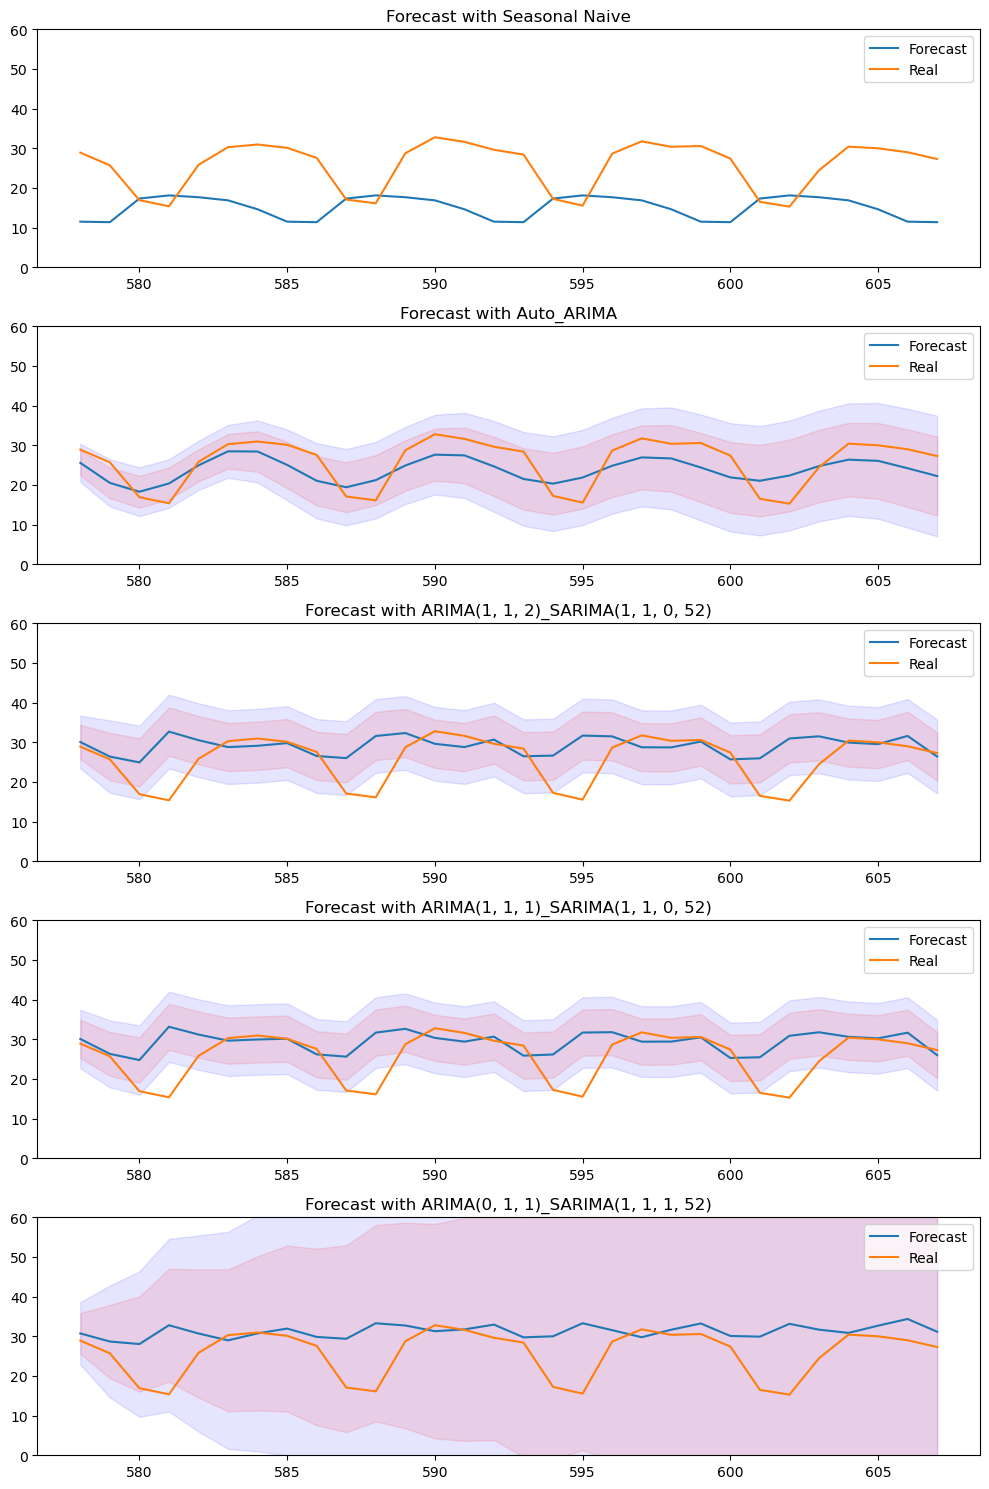

In [57]:
# Create a list of models and their names for iteration
models = [ (seasonal_naive_test_preds, 'Seasonal Naive'),
          (auto_model, 'Auto_ARIMA'), 
          (sarima111_fit, 'ARIMA(1, 1, 2)_SARIMA(1, 1, 0, 52)'),
          (sarima110_fit, 'ARIMA(1, 1, 1)_SARIMA(1, 1, 0, 52)'),
          (sarima120_fit, 'ARIMA(1, 1, 1)_SARIMA(0, 1, 1, 52)')]

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

# Iterate over each model
for ax, (model, name) in zip(axes, models):
    # Make predictions
    if model != seasonal_naive_test_preds: 
        forecast = model.get_forecast(steps=len(x_test)).predicted_mean
        forecast.index = x_test.index
        
        # Plot forecast
        ax.plot(x_test.index, forecast, label='Forecast')
        ax.plot(x_test.index, x_test, label='Real')
        ax.set_title(f'Forecast with {name}')
        ax.legend()
    
        # Plot prediction intervals if available
       
        pred_ci_95= model.get_forecast(steps=len(x_test)).conf_int()#default alpha=0.05 95% CI
        pred_ci_80 = model.get_forecast(steps=len(x_test)).conf_int(alpha=0.2)
    
        ax.fill_between(x_test.index, pred_ci_95.iloc[:, 0], pred_ci_95.iloc[:, 1], color='b', alpha=0.1)
        ax.fill_between(x_test.index, pred_ci_80.iloc[:, 0], pred_ci_80.iloc[:, 1], color='r', alpha=0.1)
    
        # Set y-axis limits
        ax.set_ylim(0, 60)
    else:
        # Plot forecast
        ax.plot(x_test.index, model, label='Forecast')
        ax.plot(x_test.index, x_test, label='Real')
        ax.set_title(f'Forecast with {name}')
        ax.legend()

        ax.set_ylim(0, 60)

# Adjust layout
plt.tight_layout()
plt.show()

The best is autoarima

repetir el código para ver bien cual sería el que yo predije ARIMA (1,1,1) SARIMA(0,1,1) y ver como ha salido

### 5.4. Junction 3

IMP:  NO SEASONALITY!!! NO TREND

#### Experiment 1: 4 months training window and 3 set cross validation

In [58]:
# CROSS VALIDATION SET 1 
train_indices = exp1_splits.loc[exp1_splits['Cross-Validation Set'] == 1, 'Train Indices'].iloc[0]
test_indices = exp1_splits.loc[exp1_splits['Cross-Validation Set'] == 1, 'Test Indices'].iloc[0]

# Extract the 'Vehicles' column as the input for all models
x_train = data_junction_3.iloc[train_indices]['Vehicles']
x_test = data_junction_3.iloc[test_indices]['Vehicles']

# Define manual models and seasonal orders
natural_orders = [(1, 0, 0), (0, 0, 1), (1, 0, 1), (2, 0, 1), (1, 0, 2)]
# Perform automatic model selection using auto_arima
auto_model = auto_arima(x_train, 
                        start_p=0, start_q=0,
                        max_p=2, max_q=2,
                        d=0, max_d=2,
                        seasonal=False, 
                        stepwise=True, # Grid Search
                        suppress_warnings=True, 
                        error_action='ignore', 
                        trace=True,
                        information_criterion='aicc')  # You can choose 'aic', 'bic', 'hqic', 'oob', or 'aicc'

# Create an empty DataFrame to store the results
exp1_results = pd.DataFrame(columns=['CV set','Model', 'MAE', 'RMSE'])

# Fit and forecast using the fitted auto_arima model
auto_model.fit(x_train)
auto_forecast, auto_conf_int = auto_model.predict(n_periods=len(x_test), return_conf_int=True)
auto_mae = mean_absolute_error(x_test, auto_forecast)
auto_rmse = np.sqrt(mean_squared_error(x_test, auto_forecast))

# Append results to the DataFrame
exp1_results = pd.concat([exp1_results, pd.DataFrame([[1, 'Auto_ARIMA', auto_mae, auto_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)


# Train ARIMA models for each combination
for i, natural_order in enumerate(natural_orders, start=1):
    # Define model name
    model_name = f'ARIMA{natural_order}'
    
    # Fit ARIMA model
    arima_model = ARIMA(x_train, order=natural_order)
    arima_fit = arima_model.fit()
    
    # Forecast
    arima_forecast = arima_fit.predict(start=len(x_train), end=len(x_train) + len(x_test) - 1, typ='levels')
    
    # Compute errors
    arima_mae = mean_absolute_error(x_test, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(x_test, arima_forecast))
    
    # Append ARIMA results to DataFrame
    exp1_results = pd.concat([exp1_results, pd.DataFrame([[1, model_name, arima_mae, arima_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)

# Print the results DataFrame
exp1_results

Performing stepwise search to minimize aicc
 ARIMA(0,0,0)(0,0,0)[0]             : AICC=883.934, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AICC=603.803, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AICC=770.904, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AICC=599.503, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AICC=600.481, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AICC=598.347, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AICC=600.461, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AICC=725.891, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AICC=600.460, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AICC=594.977, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AICC=659.630, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AICC=597.064, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AICC=597.125, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AICC=596.932, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercep

,CV set,Model,MAE,RMSE
0,1,Auto_ARIMA,2.873383,4.066001
1,1,"ARIMA(1, 0, 0)",3.304940,4.949131
2,1,"ARIMA(0, 0, 1)",4.680552,6.643587
3,1,"ARIMA(1, 0, 1)",2.873372,4.066032
4,1,"ARIMA(2, 0, 1)",2.875626,4.092879
5,1,"ARIMA(1, 0, 2)",2.936146,4.322577


In [59]:
# CROSS VALIDATION SET 2
warnings.filterwarnings("ignore")
train_indices = exp1_splits.loc[exp1_splits['Cross-Validation Set'] == 2, 'Train Indices'].iloc[0]
test_indices = exp1_splits.loc[exp1_splits['Cross-Validation Set'] == 2, 'Test Indices'].iloc[0]

# Define manual models and seasonal orders
# Perform automatic model selection using auto_arima
auto_model = auto_arima(x_train, 
                        start_p=0, start_q=0,
                        max_p=2, max_q=2,
                        d=0, max_d=2,
                        seasonal=False, 
                        stepwise=True, # Grid Search
                        suppress_warnings=True, 
                        error_action='ignore', 
                        trace=True,
                        information_criterion='aicc')  # You can choose 'aic', 'bic', 'hqic', 'oob', or 'aicc'

# Fit and forecast using the fitted auto_arima model
auto_model.fit(x_train)
auto_forecast, auto_conf_int = auto_model.predict(n_periods=len(x_test), return_conf_int=True)
auto_mae = mean_absolute_error(x_test, auto_forecast)
auto_rmse = np.sqrt(mean_squared_error(x_test, auto_forecast))

# Append results to the DataFrame
exp1_results = pd.concat([exp1_results, pd.DataFrame([[2, 'Auto_ARIMA', auto_mae, auto_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)


# Train ARIMA models for each combination
for i, natural_order in enumerate(natural_orders, start=1):
    # Define model name
    model_name = f'ARIMA{natural_order}'
    
    # Fit ARIMA model
    arima_model = ARIMA(x_train, order=natural_order)
    arima_fit = arima_model.fit()
    
    # Forecast
    arima_forecast = arima_fit.predict(start=len(x_train), end=len(x_train) + len(x_test) - 1, typ='levels')
    
    # Compute errors
    arima_mae = mean_absolute_error(x_test, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(x_test, arima_forecast))
    
    # Append ARIMA results to DataFrame
    exp1_results = pd.concat([exp1_results, pd.DataFrame([[2, model_name, arima_mae, arima_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)

# Print the results DataFrame
exp1_results

Performing stepwise search to minimize aicc
 ARIMA(0,0,0)(0,0,0)[0]             : AICC=883.934, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AICC=603.803, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AICC=770.904, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AICC=599.503, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AICC=600.481, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AICC=598.347, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AICC=600.461, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AICC=725.891, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AICC=600.460, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AICC=594.977, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AICC=659.630, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AICC=597.064, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AICC=597.125, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AICC=596.932, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercep

,CV set,Model,MAE,RMSE
0,1,Auto_ARIMA,2.873383,4.066001
1,1,"ARIMA(1, 0, 0)",3.304940,4.949131
2,1,"ARIMA(0, 0, 1)",4.680552,6.643587
3,1,"ARIMA(1, 0, 1)",2.873372,4.066032
4,1,"ARIMA(2, 0, 1)",2.875626,4.092879
5,1,"ARIMA(1, 0, 2)",2.936146,4.322577
6,2,Auto_ARIMA,2.873383,4.066001
7,2,"ARIMA(1, 0, 0)",3.304940,4.949131
8,2,"ARIMA(0, 0, 1)",4.680552,6.643587
9,2,"ARIMA(1, 0, 1)",2.873372,4.066032


In [60]:
# CROSS VALIDATION SET 3
warnings.filterwarnings("ignore")
train_indices = exp1_splits.loc[exp1_splits['Cross-Validation Set'] == 3, 'Train Indices'].iloc[0]
test_indices = exp1_splits.loc[exp1_splits['Cross-Validation Set'] == 3, 'Test Indices'].iloc[0]

# Perform automatic model selection using auto_arima
auto_model = auto_arima(x_train, 
                        start_p=0, start_q=0,
                        max_p=2, max_q=2,
                        d=0, max_d=2,
                        seasonal=False, 
                        stepwise=True, # Grid Search
                        suppress_warnings=True, 
                        error_action='ignore', 
                        trace=True,
                        information_criterion='aicc')  # You can choose 'aic', 'bic', 'hqic', 'oob', or 'aicc'

# Fit and forecast using the fitted auto_arima model
auto_model.fit(x_train)
auto_forecast, auto_conf_int = auto_model.predict(n_periods=len(x_test), return_conf_int=True)
auto_mae = mean_absolute_error(x_test, auto_forecast)
auto_rmse = np.sqrt(mean_squared_error(x_test, auto_forecast))

# Append results to the DataFrame
exp1_results = pd.concat([exp1_results, pd.DataFrame([[3, 'Auto_ARIMA', auto_mae, auto_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)


# Train ARIMA models for each combination
for i, natural_order in enumerate(natural_orders, start=1):
    # Define model name
    model_name = f'ARIMA{natural_order}'
    
    # Fit ARIMA model
    arima_model = ARIMA(x_train, order=natural_order)
    arima_fit = arima_model.fit()
    
    # Forecast
    arima_forecast = arima_fit.predict(start=len(x_train), end=len(x_train) + len(x_test) - 1, typ='levels')
    
    # Compute errors
    arima_mae = mean_absolute_error(x_test, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(x_test, arima_forecast))
    
    # Append ARIMA results to DataFrame
    exp1_results = pd.concat([exp1_results, pd.DataFrame([[3, model_name, arima_mae, arima_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)

# Print the results DataFrame
exp1_results

Performing stepwise search to minimize aicc
 ARIMA(0,0,0)(0,0,0)[0]             : AICC=883.934, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AICC=603.803, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AICC=770.904, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AICC=599.503, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AICC=600.481, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AICC=598.347, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AICC=600.461, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AICC=725.891, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AICC=600.460, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AICC=594.977, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AICC=659.630, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AICC=597.064, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AICC=597.125, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AICC=596.932, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercep

,CV set,Model,MAE,RMSE
0,1,Auto_ARIMA,2.873383,4.066001
1,1,"ARIMA(1, 0, 0)",3.304940,4.949131
2,1,"ARIMA(0, 0, 1)",4.680552,6.643587
3,1,"ARIMA(1, 0, 1)",2.873372,4.066032
4,1,"ARIMA(2, 0, 1)",2.875626,4.092879
5,1,"ARIMA(1, 0, 2)",2.936146,4.322577
6,2,Auto_ARIMA,2.873383,4.066001
7,2,"ARIMA(1, 0, 0)",3.304940,4.949131
8,2,"ARIMA(0, 0, 1)",4.680552,6.643587
9,2,"ARIMA(1, 0, 1)",2.873372,4.066032


In [61]:
# Group by the 'Model' column
model_group = exp1_results.groupby('Model')

# Calculate the mean of MAE and RMSE for each model
exp1_results = model_group[['MAE', 'RMSE']].mean()

# Print the mean metrics
exp1_results

,MAE,RMSE
Model,,
"ARIMA(0, 0, 1)",4.680552,6.643587
"ARIMA(1, 0, 0)",3.304940,4.949131
"ARIMA(1, 0, 1)",2.873372,4.066032
"ARIMA(1, 0, 2)",2.936146,4.322577
"ARIMA(2, 0, 1)",2.875626,4.092879
Auto_ARIMA,2.873383,4.066001


#### Experiment 2: 6 months training window and 2 set cross validation

In [62]:
# CROSS VALIDATION SET 1 
# Create an empty DataFrame to store the results
exp2_results = pd.DataFrame(columns=['CV set','Model', 'MAE', 'RMSE'])

train_indices = exp2_splits.loc[exp2_splits['Cross-Validation Set'] == 1, 'Train Indices'].iloc[0]
test_indices = exp2_splits.loc[exp2_splits['Cross-Validation Set'] == 1, 'Test Indices'].iloc[0]

# Perform automatic model selection using auto_arima
auto_model = auto_arima(x_train, 
                        start_p=0, start_q=0,
                        max_p=2, max_q=2,
                        d=0, max_d=2,
                        seasonal=False, 
                        stepwise=True, # Grid Search
                        suppress_warnings=True, 
                        error_action='ignore', 
                        trace=True,
                        information_criterion='aicc')  # You can choose 'aic', 'bic', 'hqic', 'oob', or 'aicc'

# Fit and forecast using the fitted auto_arima model
auto_model.fit(x_train)
auto_forecast, auto_conf_int = auto_model.predict(n_periods=len(x_test), return_conf_int=True)
auto_mae = mean_absolute_error(x_test, auto_forecast)
auto_rmse = np.sqrt(mean_squared_error(x_test, auto_forecast))

# Append results to the DataFrame
exp2_results = pd.concat([exp2_results, pd.DataFrame([[1, 'Auto_ARIMA', auto_mae, auto_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)


# Train ARIMA models for each combination
for i, natural_order in enumerate(natural_orders, start=1):
    # Define model name
    model_name = f'ARIMA{natural_order}'
    
    # Fit ARIMA model
    arima_model = ARIMA(x_train, order=natural_order)
    arima_fit = arima_model.fit()
    
    # Forecast
    arima_forecast = arima_fit.predict(start=len(x_train), end=len(x_train) + len(x_test) - 1, typ='levels')
    
    # Compute errors
    arima_mae = mean_absolute_error(x_test, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(x_test, arima_forecast))
    
    # Append ARIMA results to DataFrame
    exp2_results = pd.concat([exp2_results, pd.DataFrame([[1, model_name, arima_mae, arima_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)

# Print the results DataFrame
exp2_results

Performing stepwise search to minimize aicc
 ARIMA(0,0,0)(0,0,0)[0]             : AICC=883.934, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AICC=603.803, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AICC=770.904, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AICC=599.503, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AICC=600.481, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AICC=598.347, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AICC=600.461, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AICC=725.891, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AICC=600.460, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AICC=594.977, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AICC=659.630, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AICC=597.064, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AICC=597.125, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AICC=596.932, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercep

,CV set,Model,MAE,RMSE
0,1,Auto_ARIMA,2.873383,4.066001
1,1,"ARIMA(1, 0, 0)",3.304940,4.949131
2,1,"ARIMA(0, 0, 1)",4.680552,6.643587
3,1,"ARIMA(1, 0, 1)",2.873372,4.066032
4,1,"ARIMA(2, 0, 1)",2.875626,4.092879
5,1,"ARIMA(1, 0, 2)",2.936146,4.322577


In [63]:
# CROSS VALIDATION SET 2
train_indices = exp2_splits.loc[exp2_splits['Cross-Validation Set'] == 2, 'Train Indices'].iloc[0]
test_indices = exp2_splits.loc[exp2_splits['Cross-Validation Set'] == 2, 'Test Indices'].iloc[0]

# Extract the 'Vehicles' column as the input for all models
x_train = data_junction_3.iloc[train_indices]['Vehicles']
x_test = data_junction_3.iloc[test_indices]['Vehicles']

# Perform automatic model selection using auto_arima
auto_model = auto_arima(x_train, 
                        start_p=0, start_q=0,
                        max_p=2, max_q=2,
                        d=0, max_d=2,
                        seasonal=False, 
                        stepwise=True, # Grid Search
                        suppress_warnings=True, 
                        error_action='ignore', 
                        trace=True,
                        information_criterion='aicc')  # You can choose 'aic', 'bic', 'hqic', 'oob', or 'aicc'

# Fit and forecast using the fitted auto_arima model
auto_model.fit(x_train)
auto_forecast, auto_conf_int = auto_model.predict(n_periods=len(x_test), return_conf_int=True)
auto_mae = mean_absolute_error(x_test, auto_forecast)
auto_rmse = np.sqrt(mean_squared_error(x_test, auto_forecast))

# Append results to the DataFrame
exp2_results = pd.concat([exp2_results, pd.DataFrame([[2, 'Auto_ARIMA', auto_mae, auto_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)


# Train ARIMA models for each combination
for i, natural_order in enumerate(natural_orders, start=1):
    # Define model name
    model_name = f'ARIMA{natural_order}'
    
    # Fit ARIMA model
    arima_model = ARIMA(x_train, order=natural_order)
    arima_fit = arima_model.fit()
    
    # Forecast
    arima_forecast = arima_fit.predict(start=len(x_train), end=len(x_train) + len(x_test) - 1, typ='levels')
    
    # Compute errors
    arima_mae = mean_absolute_error(x_test, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(x_test, arima_forecast))
    
    # Append ARIMA results to DataFrame
    exp2_results = pd.concat([exp2_results, pd.DataFrame([[2, model_name, arima_mae, arima_rmse]], columns=['CV set','Model', 'MAE', 'RMSE'])], ignore_index=True)


Performing stepwise search to minimize aicc
 ARIMA(0,0,0)(0,0,0)[0]             : AICC=1482.975, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AICC=1028.147, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AICC=1302.543, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AICC=1030.162, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AICC=1030.151, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AICC=1032.225, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AICC=1007.844, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AICC=1157.352, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AICC=1008.243, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AICC=1008.487, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AICC=1060.553, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AICC=1010.266, Time=0.18 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.750 seconds


In [64]:
# Group by the 'Model' column
model_group = exp2_results.groupby('Model')

# Calculate the mean of MAE and RMSE for each model
exp2_results = model_group[['MAE', 'RMSE']].mean()

# Print the mean metrics
exp2_results
results_j3= pd.concat([exp1_results, exp2_results], axis=1)
results_j3

,MAE,RMSE,MAE,RMSE
Model,,,,
"ARIMA(0, 0, 1)",4.680552,6.643587,3.701635,5.411322
"ARIMA(1, 0, 0)",3.304940,4.949131,3.015068,4.489503
"ARIMA(1, 0, 1)",2.873372,4.066032,2.789281,4.059544
"ARIMA(1, 0, 2)",2.936146,4.322577,2.831534,4.207346
"ARIMA(2, 0, 1)",2.875626,4.092879,2.791641,4.074759
Auto_ARIMA,2.873383,4.066001,2.799265,4.047960


En general, podemos ver que el experimento 2 ha dado mejores resultados, asi que elejimos una train window de 6 meses. Sin embargo podemos ver como en este caso la diferencia es mucho menor que en los ejemplos anteriores.  
our suggested method ARIMA(1,0,0)
, got3.015068 and 4.489503E, whichare awfull!!


Lets better observe how the predictions lookr.

#### Forecasting visualization

As for this Time Series we do not have seasonality, we create the naive model by forecasting always the last value from the training set.

In [65]:
test_start = '2017-06-01'
test_start_date = datetime.strptime(test_start, '%Y-%m-%d')
train_start_date = test_start_date - timedelta(days=6*30)  # Restar 6 meses
x_train = data_junction_3[(data_junction_3['Date'] >= train_start_date.strftime('%Y-%m-%d')) & 
                          (data_junction_3['Date'] < test_start)]['Vehicles']
x_test = data_junction_3[data_junction_3['Date'] >= test_start]['Vehicles']

# Naive Model: Forecast equals the last value from the training set
naive_train_preds = [x_train.iloc[-1]] * len(x_train)
naive_test_preds = [x_train.iloc[-1]] * len(x_test)

# Calculate MAE and RMSE for Naive Model
naive_train_mae = mean_absolute_error(x_train, naive_train_preds)
naive_test_mae = mean_absolute_error(x_test, naive_test_preds)
naive_train_rmse = np.sqrt(mean_squared_error(x_train, naive_train_preds))
naive_test_rmse = np.sqrt(mean_squared_error(x_test, naive_test_preds))

# Initialize lists to store results
models = ['Naive', 'ARIMA(1, 0, 0)', 'ARIMA(1, 0, 1)', 'ARIMA(1, 0, 2)', 'ARIMA(2, 0, 1)']
train_mae = [naive_train_mae]
test_mae = [naive_test_mae]
train_rmse = [naive_train_rmse]
test_rmse = [naive_test_rmse]


In [66]:
warnings.filterwarnings("ignore")
# ARIMA(1, 0, 0)
arima100_model = ARIMA(x_train, order=(1, 0, 0))
arima100_fit = arima100_model.fit()
# Calculate metrics for SARIMA(1,1,1)(1,1,1,52)
sarima100_train_preds = arima100_fit.predict(typ='levels')
sarima100_test_preds = arima100_fit.forecast(steps=len(x_test))

train_mae.append(mean_absolute_error(x_train, sarima100_train_preds))
test_mae.append(mean_absolute_error(x_test, sarima100_test_preds))
train_rmse.append(np.sqrt(mean_squared_error(x_train, sarima100_train_preds)))
test_rmse.append(np.sqrt(mean_squared_error(x_test, sarima100_test_preds)))

# ARIMA(1, 0, 1)
arima101_model = ARIMA(x_train, order=(1, 0, 1))
arima101_fit = arima101_model.fit()
sarima101_train_preds = arima101_fit.predict(typ='levels')
sarima101_test_preds = arima101_fit.forecast(steps=len(x_test))

train_mae.append(mean_absolute_error(x_train, sarima101_train_preds))
test_mae.append(mean_absolute_error(x_test, sarima101_test_preds))
train_rmse.append(np.sqrt(mean_squared_error(x_train, sarima101_train_preds)))
test_rmse.append(np.sqrt(mean_squared_error(x_test, sarima101_test_preds)))

# ARIMA(1, 0, 2)
arima102_model = ARIMA(x_train, order=(1, 0, 2))
arima102_fit = arima102_model.fit()
sarima102_train_preds = arima102_fit.predict(typ='levels')
sarima102_test_preds = arima102_fit.forecast(steps=len(x_test))

train_mae.append(mean_absolute_error(x_train, sarima102_train_preds))
test_mae.append(mean_absolute_error(x_test, sarima102_test_preds))
train_rmse.append(np.sqrt(mean_squared_error(x_train, sarima102_train_preds)))
test_rmse.append(np.sqrt(mean_squared_error(x_test, sarima102_test_preds)))

# ARIMA(2,0,1)
arima201_model = ARIMA(x_train, order=(2, 0, 1))
arima201_fit = arima201_model.fit()
sarima201_train_preds = arima201_fit.predict(typ='levels')
sarima201_test_preds = arima201_fit.forecast(steps=len(x_test))

train_mae.append(mean_absolute_error(x_train, sarima201_train_preds))
test_mae.append(mean_absolute_error(x_test, sarima201_test_preds))
train_rmse.append(np.sqrt(mean_squared_error(x_train, sarima201_train_preds)))
test_rmse.append(np.sqrt(mean_squared_error(x_test, sarima201_test_preds)))

# Store results in DataFrame
final_results = pd.DataFrame({
    'Model': models,
    'Train_MAE': train_mae,
    'Test_MAE': test_mae,
    'Train_RMSE': train_rmse,
    'Test_RMSE': test_rmse
})

final_results

,Model,Train_MAE,Test_MAE,Train_RMSE,Test_RMSE
0,Naive,4.133102,3.738889,5.662099,4.995160
1,"ARIMA(1, 0, 0)",2.791618,3.752100,4.154997,5.015048
2,"ARIMA(1, 0, 1)",2.772491,3.754960,4.147911,5.019247
3,"ARIMA(1, 0, 2)",2.768311,3.756162,4.145577,5.018854
4,"ARIMA(2, 0, 1)",2.768013,3.752737,4.145930,5.016111


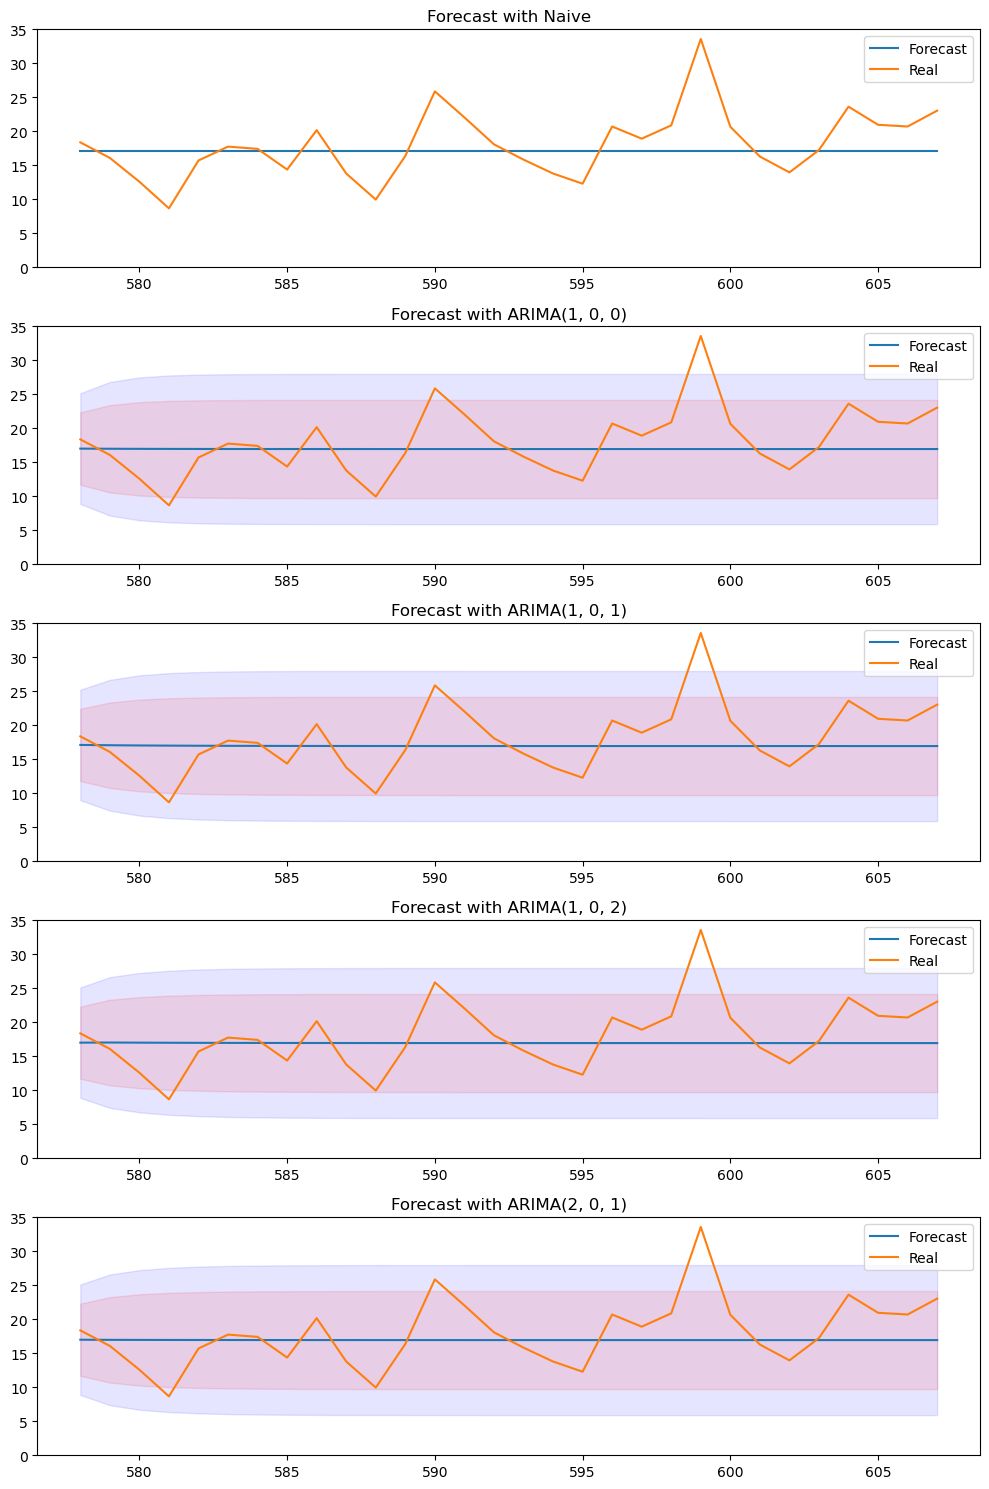

In [67]:
# Create a list of models and their names for iteration
models = [ (naive_test_preds, 'Naive'),
          (arima100_fit, 'ARIMA(1, 0, 0)'),
          (arima101_fit, 'ARIMA(1, 0, 1)'),
          (arima102_fit, 'ARIMA(1, 0, 2)'),
          (arima201_fit, 'ARIMA(2, 0, 1)')]

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

# Iterate over each model
for ax, (model, name) in zip(axes, models):
    # Make predictions
    if model != naive_test_preds: 
        forecast = model.get_forecast(steps=len(x_test)).predicted_mean
        forecast.index = x_test.index
        
        # Plot forecast
        ax.plot(x_test.index, forecast, label='Forecast')
        ax.plot(x_test.index, x_test, label='Real')
        ax.set_title(f'Forecast with {name}')
        ax.legend()
    
        # Plot prediction intervals if available
       
        pred_ci_95= model.get_forecast(steps=len(x_test)).conf_int()#default alpha=0.05 95% CI
        pred_ci_80 = model.get_forecast(steps=len(x_test)).conf_int(alpha=0.2)
    
        ax.fill_between(x_test.index, pred_ci_95.iloc[:, 0], pred_ci_95.iloc[:, 1], color='b', alpha=0.1)
        ax.fill_between(x_test.index, pred_ci_80.iloc[:, 0], pred_ci_80.iloc[:, 1], color='r', alpha=0.1)
    
        # Set y-axis limits
        ax.set_ylim(0, 35)
    else:
        # Plot forecast
        ax.plot(x_test.index, model, label='Forecast')
        ax.plot(x_test.index, x_test, label='Real')
        ax.set_title(f'Forecast with {name}')
        ax.legend()

        ax.set_ylim(0, 35)

# Adjust layout
plt.tight_layout()
plt.show()

Como podemos ver, casi todos los modelos lo hacen igual, pero no exactamente porque ya vimos que los valores de las métricas no eran los mismos. Como recordamos, este dataset tiene varios outliers y tal vez esta sea la razón por la que es más dificil encontrar un modelo que funcione para predecir correctamente. En este caso el modelo naive que predice el último valor del train set ha conseguido mucho mejor resultado que cualquiera de los demás.

Otro aspecto a comentar es que los intervalos de predicción son muy amplios en todos los casos, demostrando el nivel de incertisumbre de estos modelos.

### 5.5. Junction 4

IMP: COMO EL TAMAÑO DE ESTOS DATOS ES MENOR, AQUI NO HACEMOS CV, SOLO 1 TRY PARA CADA EXPERIMENTO

si trend, no seasonality

In [68]:
results_j4 = pd.DataFrame(columns=['Model', 'Train_MAE','Test_MAE', 'Train_RMSE', 'Test_RMSE'])

test_start = '2017-06-01'
test_start_date = datetime.strptime(test_start, '%Y-%m-%d')
train_start_date = test_start_date - timedelta(days=6*30)  # Restar 6 meses
x_train = data_junction_4[(data_junction_4['Date'] >= train_start_date.strftime('%Y-%m-%d')) & 
                          (data_junction_4['Date'] < test_start)]['Vehicles']
x_test = data_junction_4[data_junction_4['Date'] >= test_start]['Vehicles']

# Naive Model: Forecast equals the last value from the training set
naive_train_preds = [x_train.iloc[-1]] * len(x_train)
naive_test_preds = [x_train.iloc[-1]] * len(x_test)

# Calculate MAE and RMSE for Naive Model
naive_train_mae = mean_absolute_error(x_train, naive_train_preds)
naive_test_mae = mean_absolute_error(x_test, naive_test_preds)
naive_train_rmse = np.sqrt(mean_squared_error(x_train, naive_train_preds))
naive_test_rmse = np.sqrt(mean_squared_error(x_test, naive_test_preds))

results_j4 = pd.concat([results_j4, pd.DataFrame([['Naive', naive_train_mae, naive_test_mae, naive_train_rmse, naive_test_rmse]], columns=['Model', 'Train_MAE', 'Test_MAE', 'Train_RMSE', 'Test_RMSE'])], ignore_index=True)


In [69]:
# Define manual models and seasonal orders
natural_orders = [(1, 1, 0), (0, 1, 1), (1, 1, 1), (2, 1, 1), (1, 1, 2)]
# Perform automatic model selection using auto_arima
auto_model = auto_arima(x_train, 
                        start_p=0, start_q=0,
                        max_p=2, max_q=2,
                        d=1, max_d=2,
                        seasonal=False, 
                        stepwise=True, # Grid Search
                        suppress_warnings=True, 
                        error_action='ignore', 
                        trace=True,
                        information_criterion='aicc')  # You can choose 'aic', 'bic', 'hqic', 'oob', or 'aicc'


# Fit and forecast using the fitted auto_arima model
auto_model.fit(x_train)
auto_forecast, auto_conf_int = auto_model.predict(n_periods=len(x_test), return_conf_int=True)
auto_mae = mean_absolute_error(x_test, auto_forecast)
auto_rmse = np.sqrt(mean_squared_error(x_test, auto_forecast))
# Get predictions on the training set
auto_train_forecast = auto_model.predict_in_sample()
auto_train_mae = mean_absolute_error(x_train, auto_train_forecast)
auto_train_rmse = np.sqrt(mean_squared_error(x_train, auto_train_forecast))
# Append results to the DataFrame
results_j4 = pd.concat([results_j4, pd.DataFrame([['Auto_ARIMA', auto_train_mae, auto_mae, auto_train_rmse, auto_rmse]],columns=['Model', 'Train_MAE', 'Test_MAE', 'Train_RMSE', 'Test_RMSE'])], ignore_index=True)


Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AICC=511.086, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AICC=501.630, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AICC=488.236, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AICC=509.092, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AICC=474.740, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AICC=476.766, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AICC=477.770, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AICC=475.189, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AICC=495.157, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AICC=inf, Time=0.46 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AICC=473.083, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AICC=486.154, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AICC=499.616, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AICC=475.023, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             

In [70]:
# Create an empty dictionary to store the fitted ARIMA models
fitted_models = {}

# Train ARIMA models for each combination
for i, natural_order in enumerate(natural_orders, start=1):
    # Define model name
    model_name = f'ARIMA{natural_order}'
    
    # Fit ARIMA model
    arima_model = ARIMA(x_train, order=natural_order)
    arima_fit = arima_model.fit()
    
    # Save the fitted ARIMA model
    fitted_models[model_name] = arima_fit
    
    # Forecast on the training set
    arima_train_forecast = arima_fit.predict(typ='levels')
    
    # Compute errors for training set
    arima_train_mae = mean_absolute_error(x_train, arima_train_forecast)
    arima_train_rmse = np.sqrt(mean_squared_error(x_train, arima_train_forecast))
    
    # Forecast on the test set
    arima_forecast = arima_fit.predict(start=len(x_train), end=len(x_train) + len(x_test) - 1, typ='levels')
    
    # Compute errors for test set
    arima_mae = mean_absolute_error(x_test, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(x_test, arima_forecast))
    
    # Append ARIMA results to DataFrame
    results_j4 = pd.concat([results_j4, pd.DataFrame([[model_name, arima_train_mae, arima_mae, arima_train_rmse, arima_rmse]], columns=['Model', 'Train_MAE', 'Test_MAE', 'Train_RMSE', 'Test_RMSE'])], ignore_index=True)

# Print the results DataFrame
results_j4


,Model,Train_MAE,Test_MAE,Train_RMSE,Test_RMSE
0,Naive,1.332781,1.279167,1.594340,1.776958
1,Auto_ARIMA,0.885751,1.888334,1.199134,2.450838
2,"ARIMA(1, 1, 0)",0.977765,1.279167,1.299313,1.776958
3,"ARIMA(0, 1, 1)",0.944661,1.606827,1.259199,2.210711
4,"ARIMA(1, 1, 1)",0.885751,1.888334,1.199134,2.450838
5,"ARIMA(2, 1, 1)",0.886557,1.892014,1.198705,2.454566
6,"ARIMA(1, 1, 2)",0.884715,1.767818,1.206385,2.357064


The best one appear to be ARIMA(1,1,0), AS WE EXPECTED!!! but again the naive performs as best as the other 

autoarima chooses 1,1,1, having not great results. Let's better observe them:




#### Forecasting visualization

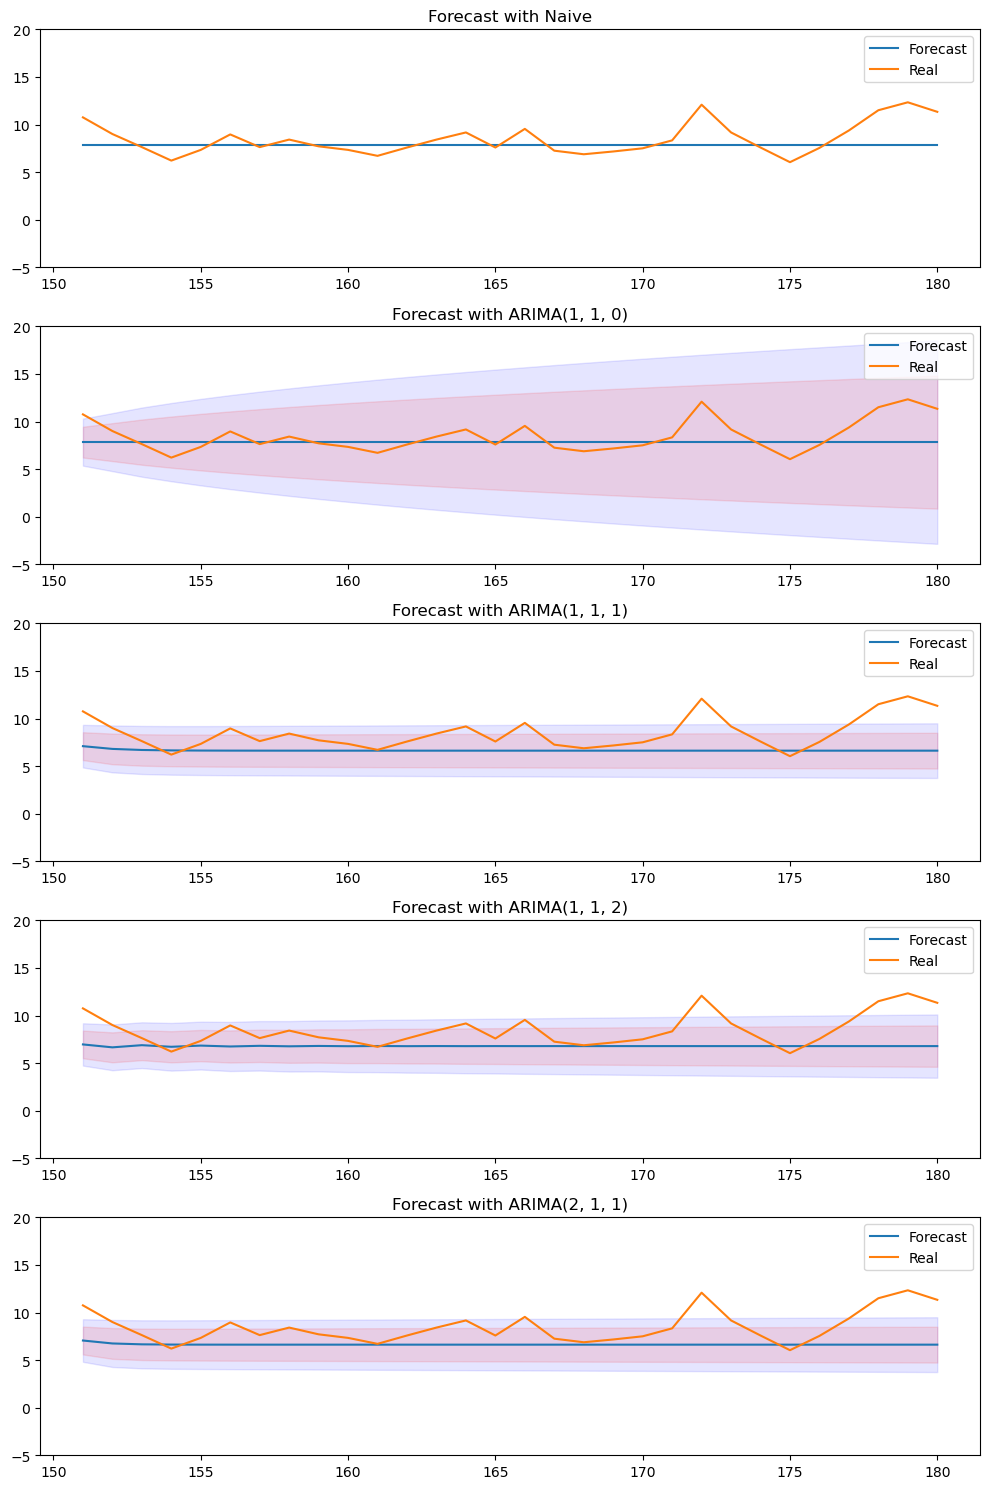

In [72]:
# Create a list of models and their names for iteration
models = [ (naive_test_preds, 'Naive'),
          (fitted_models['ARIMA(1, 1, 0)'], 'ARIMA(1, 1, 0)'),
          (fitted_models['ARIMA(1, 1, 1)'], 'ARIMA(1, 1, 1)'),
          (fitted_models['ARIMA(1, 1, 2)'], 'ARIMA(1, 1, 2)'),
          (fitted_models['ARIMA(2, 1, 1)'], 'ARIMA(2, 1, 1)')]

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

# Iterate over each model
for ax, (model, name) in zip(axes, models):
    # Make predictions
    if model != naive_test_preds: 
        forecast = model.get_forecast(steps=len(x_test)).predicted_mean
        forecast.index = x_test.index
        
        # Plot forecast
        ax.plot(x_test.index, forecast, label='Forecast')
        ax.plot(x_test.index, x_test, label='Real')
        ax.set_title(f'Forecast with {name}')
        ax.legend()
    
        # Plot prediction intervals if available
       
        pred_ci_95= model.get_forecast(steps=len(x_test)).conf_int()#default alpha=0.05 95% CI
        pred_ci_80 = model.get_forecast(steps=len(x_test)).conf_int(alpha=0.2)
    
        ax.fill_between(x_test.index, pred_ci_95.iloc[:, 0], pred_ci_95.iloc[:, 1], color='b', alpha=0.1)
        ax.fill_between(x_test.index, pred_ci_80.iloc[:, 0], pred_ci_80.iloc[:, 1], color='r', alpha=0.1)
    
        # Set y-axis limits
        ax.set_ylim(-5, 20)
    else:
        # Plot forecast
        ax.plot(x_test.index, model, label='Forecast')
        ax.plot(x_test.index, x_test, label='Real')
        ax.set_title(f'Forecast with {name}')
        ax.legend()

        ax.set_ylim(-5, 20)

# Adjust layout
plt.tight_layout()
plt.show()

The supposed to be the best model has the bigger prediciton intervals?¿? me pego un tiro

## 6. Conclusions

Interpretation and conclusions (accuracy and reliability of your forecasts, potential limitations, and
the implications of your ndings)

Resumen: los modelos predecidos con los AC de la junction 1 y 2 no han sido la mejor aproximación porque al ser modelos de orden 2 era más difícil de visualizar en los plots, pero el auto arima ha funcionado realmente bien captando estos modelos. Finalmente en ambos casos con el modelo de auto arima se consiguen resultados bastante buenos

En cuanto a la junction 3 ninguno de los modelos pareció dar ningún resultado válido, todos hacían lo mismo que un naive. Esto se puede deber a los outliers que había en los datos que han dificultado el proceso de obtención de un modelo válido.

En cuento a la junction 4 hemos sido capaces de vilumbrar que le mejor modelo era el ARIMA(1,1,0) pero otra vez el naive consigue el mismo resultado con mucho menos esfuerzo. Como en este caso teníamos mucho menos datos que en los anteriores, es más difícil encontrar el modelo adecuado ya que no pudimos hacer CV. Se necesitarían más datos para observar mejor las características de este time series, e incluso tal vez así podríamos entrenar con una train window mayor, que puede ser otra de las limitaciones. 
